In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import graph_tool.all as gt

from pyvis.network import Network
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from IPython.core.display import display
from IPython.display import IFrame

from utils.measure import *

sns.set_context("talk")

### 1. Data Preparation

In [2]:
from scipy.io import loadmat

In [3]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/ZfishModularity/data/ConnMatrixPre_cleaned.mat"
connmat = loadmat(data_path) 
data_path = "/usr/people/runzhey/seungmount/research/runzhey/ZfishModularity/data/AllCells_cleaned.mat"
cellid = loadmat(data_path) 
data_path = "/usr/people/runzhey/seungmount/research/runzhey/ZfishModularity/data/cellIDs.mat"
celltypes = loadmat(data_path) 

In [4]:
connmat = connmat["ConnMatrixPre_cleaned"]
cellid = cellid['AllCells_cleaned']
typenames = celltypes['cellIDs'].dtype
celltypes = celltypes['cellIDs'][0,0]

In [5]:
## graph construction

g = gt.Graph()
idx = connmat.T.nonzero()
g.add_edge_list(np.transpose(idx))

ew = g.new_edge_property("int32_t")
ew.a = connmat.T[idx] 
g.ep['#synapses'] = ew

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    vw[v] = cellid[i]
g.vp['cellid'] = vw

### 2. Define Neuron Types

In [6]:
neuron_type = []
for cid in cellid.T[0]:
    labelled = False
    # 16 different neuron types
    for i in range(16):
        if cid in celltypes[i][0]:
            neuron_type.append(i)
            labelled = True
            break
    if not labelled:
        # -1 indicates no type has been assigned
        neuron_type.append(-1)

In [7]:
vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    vw[v] = neuron_type[i]
g.vp['celltype'] = vw

In [8]:
vw = g.new_vertex_property("bool")
for i, v in enumerate(g.vertices()):
    vw[v] = neuron_type[i] > -1
g.vp['cellselected'] = vw

### 3. Check Isolated Neurons 

In [9]:
print(g)
print("-----------------------")
print("max out-degree is {} and in-degree is {}".format(
    max(g.degree_property_map("out")),
    max(g.degree_property_map("in"))))
print("-----------------------")
print("max out-degree is {} and in-degree is {}".format(
    min(g.degree_property_map("out")),
    min(g.degree_property_map("in"))))

<Graph object, directed, with 2883 vertices and 44969 edges, 3 internal vertex properties, 1 internal edge property, at 0x7fad0fae4710>
-----------------------
max out-degree is 165 and in-degree is 417
-----------------------
max out-degree is 0 and in-degree is 0


In [10]:
zero_deg_nodes = []
for v in g.vertices():
    if v.in_degree() == 0 and v.out_degree() == 0:
        zero_deg_nodes.append(v)
print("There are {} isolated neurons (indegree and outdegree are 0)".format(
    len(zero_deg_nodes)))

There are 59 isolated neurons (indegree and outdegree are 0)


In [11]:
for v in reversed(sorted(zero_deg_nodes)):
    g.remove_vertex(v)

In [12]:
false_annotation_nodes = []
for v in g.vertices():
    if g.vp['celltype'][v] == 14 or g.vp['celltype'][v] == 15:
        if v.out_degree() > 0:
            false_annotation_nodes.append(v)
print("There are {} abducens neurons have non-zero outdegree".format(
    len(false_annotation_nodes)))

There are 4 abducens neurons have non-zero outdegree


In [13]:
false_annotation_nodes

[<Vertex object with index '398' at 0x7fad0fb3dab0>,
 <Vertex object with index '615' at 0x7fad0faec150>,
 <Vertex object with index '2459' at 0x7fad0faec210>,
 <Vertex object with index '2810' at 0x7fad0faec1b0>]

In [14]:
# another way is to set an edge filter then prune the graph
edge_proofread = g.new_edge_property("bool")
for e in g.edges():
    if e.source in false_annotation_nodes:
        edge_proofread[e] = False
    else:
        edge_proofread[e] = True

In [15]:
g.set_edge_filter(edge_proofread)

In [16]:
g = gt.Graph(g, prune=True)
g

<Graph object, directed, with 2824 vertices and 44969 edges, 3 internal vertex properties, 1 internal edge property, at 0x7fad0fb50eb8>

### 4. Add Connectome In/Out Degrees

In [17]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/ZfishModularity/data/all_synapses.csv"
all_synapses = pd.read_csv(data_path)

In [18]:
all_synapses

,psd_segid,BBOX_bx,BBOX_by,BBOX_bz,BBOX_ex,BBOX_ey,BBOX_ez,postsyn_sz,postsyn_wt,postsyn_x,...,presyn_wt,presyn_x,presyn_y,presyn_z,size,postsyn_segid,presyn_segid,centroid_x,centroid_y,centroid_z
0,2,15037,20682,16656,15049,20719,16657,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,271,NaN,NaN,15043.0,20700.0,16656.0
1,3,15261,20788,16418,15290,20836,16419,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,253,NaN,NaN,15271.0,20811.0,16418.0
2,4,15358,20534,16389,15345,20527,16389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,259,NaN,NaN,15360.0,20533.0,16390.0
3,6,14673,22039,16487,14678,22100,16488,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,240,NaN,NaN,14675.0,22070.0,16487.0
4,7,15346,22283,16492,15325,22272,16491,25234.0,0.727412,15359.0,...,0.569262,15315.0,22298.0,16500.0,944,266713.0,266721.0,15360.0,22276.0,16492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029004,2720208,83783,43612,17610,83794,43645,17611,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,269,NaN,NaN,83787.0,43628.0,17610.0
2029005,2720210,83065,44257,17610,83109,44269,17611,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,329,NaN,NaN,83087.0,44262.0,17610.0
2029006,2720211,83279,44046,17563,83385,44096,17566,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1800,NaN,NaN,83343.0,44073.0,17564.0
2029007,2720212,83428,44518,17630,83484,44532,17631,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,315,NaN,NaN,83458.0,44524.0,17630.0


In [19]:
all_synapses.keys()

Index(['psd_segid', 'BBOX_bx', 'BBOX_by', 'BBOX_bz', 'BBOX_ex', 'BBOX_ey',
       'BBOX_ez', 'postsyn_sz', 'postsyn_wt', 'postsyn_x', 'postsyn_y',
       'postsyn_z', 'presyn_sz', 'presyn_wt', 'presyn_x', 'presyn_y',
       'presyn_z', 'size', 'postsyn_segid', 'presyn_segid', 'centroid_x',
       'centroid_y', 'centroid_z'],
      dtype='object')

In [20]:
g_cellid = [g.vp["cellid"][v] for v in g.vertices()]

In [21]:
pre_id, pre_cnt =  np.unique(all_synapses["presyn_segid"][all_synapses["presyn_segid"].isin(g_cellid)], return_counts=True)

In [22]:
pre_id2cnt = dict(zip(pre_id, pre_cnt))

In [23]:
vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    cid = g.vp["cellid"][v]
    if cid in pre_id2cnt.keys():
        vw[v] = pre_id2cnt[cid]
g.vp['#connectome_out_degree'] = vw

In [24]:
post_id, post_cnt =  np.unique(all_synapses["postsyn_segid"][all_synapses["postsyn_segid"].isin(g_cellid)], return_counts=True)

In [25]:
post_id2cnt = dict(zip(post_id, post_cnt))

In [26]:
vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    cid = g.vp["cellid"][v]
    if cid in post_id2cnt.keys():
        vw[v] = post_id2cnt[cid]
g.vp['#connectome_in_degree'] = vw

In [27]:
all_synapses["postsyn_segid"].isin(g_cellid).sum()

250460

0.40001050503317204


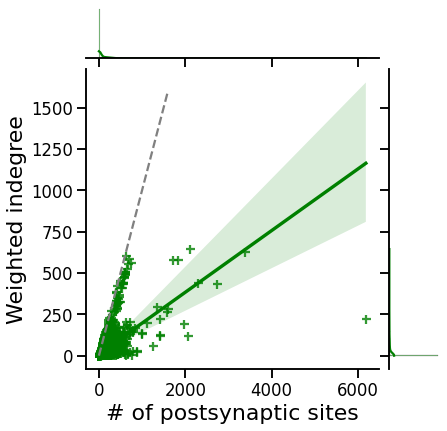

In [33]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

a = np.array([g.vp['#connectome_in_degree'][v] for v in g.vertices()])
b = np.array([v.in_degree(weight=g.ep["#synapses"]) for v in g.vertices()])
print(r2(a,b))

sns.jointplot(x=a, y=b, height=6, marker="+",
              kind="reg", color='g')
plt.plot([0,1600],[0,1600], '--',color='gray')
plt.xlabel("# of postsynaptic sites", fontsize=22)
plt.ylabel("Weighted indegree", fontsize=22)
plt.savefig("figures/paper/in-synapses-vs-connectome-synapse.pdf", 
            bbox_inches='tight')

0.6529230273807071


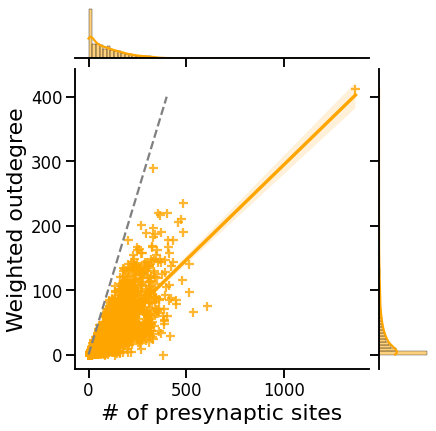

In [34]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

a = np.array([g.vp['#connectome_out_degree'][v] for v in g.vertices()])
b = np.array([v.out_degree(weight=g.ep["#synapses"]) for v in g.vertices()])
print(r2(a,b))

sns.jointplot(x=a, y=b, height=6, marker="+",
              kind="reg", color='orange')
plt.plot([0,400],[0,400], '--',color='gray')
plt.xlabel("# of presynaptic sites", fontsize=22)
plt.ylabel("Weighted outdegree", fontsize=22)
plt.savefig("figures/paper/out-synapses-vs-connectome-synapse.pdf", 
            bbox_inches='tight')

In [35]:
np.max(g.vp['#connectome_out_degree'].a), np.min(g.vp['#connectome_out_degree'].a)

(PropertyArray(1366, dtype=int32), PropertyArray(0, dtype=int32))

In [36]:
np.max(g.vp['#connectome_in_degree'].a), np.min(g.vp['#connectome_in_degree'].a)

(PropertyArray(6184, dtype=int32), PropertyArray(0, dtype=int32))

/usr/people/runzhey/miniconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


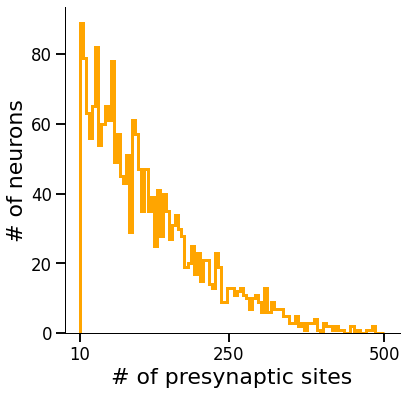

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
sns.distplot(g.vp['#connectome_out_degree'].a, kde=False, ax=ax, bins=np.linspace(10,500,100),
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "orange"})
# sns.distplot([v.out_degree(weight=g.ep["#synapses"]) for v in g.vertices()], kde=False, ax=ax, bins=np.linspace(10,500,100),
#              hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "r"})
ax.set_xticks([10,250,500])
ax.set_xlabel("# of presynaptic sites", fontsize=22)
ax.set_ylabel("# of neurons", fontsize=22)

plt.savefig("figures/paper/out-connectome-synapses-distribution.pdf", 
            bbox_inches='tight')

In [38]:
sum(g.vp['#connectome_out_degree'].a)

261587

In [39]:
sum(g.vp['#connectome_in_degree'].a)

250460

In [40]:
sum(g.ep['#synapses'].a)

75195

/usr/people/runzhey/miniconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


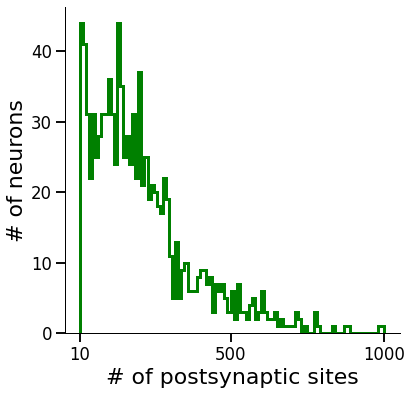

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
sns.distplot(g.vp['#connectome_in_degree'].a, kde=False, ax=ax, bins=np.linspace(10,1000,100),
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})
ax.set_xticks([10,500,1000])
ax.set_xlabel("# of postsynaptic sites", fontsize=22)
ax.set_ylabel("# of neurons", fontsize=22)

plt.savefig("figures/paper/in-connectome-synapses-distribution.pdf", 
            bbox_inches='tight')

In [42]:
center_sizes = np.zeros((4,4))
for i, th_ax in enumerate([0,50,100,150]):
    for j, th_dd in enumerate([0,100,200,300]):
        center_sizes[i, j] = sum((g.vp['#connectome_out_degree'].a > th_ax) & (g.vp['#connectome_in_degree'].a > th_dd))

In [43]:
N_cell = len(g.vp['#connectome_out_degree'].a)

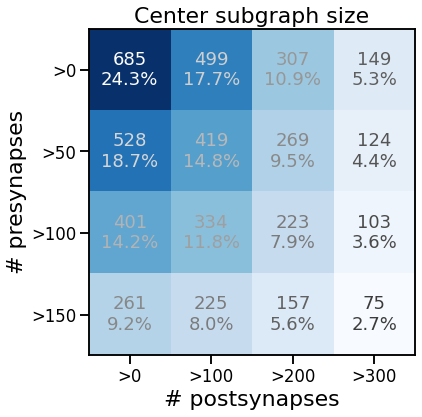

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
im = ax.imshow(center_sizes, cmap='Blues')
for i in range(4):
    for j in range(4):
        v = center_sizes[i, j]
        text = ax.text(j, i, "{:.0f}\n{:.1f}%".format(v, v/N_cell*100),
                       ha="center", va="center", color=((v/690)**0.65,
                                                        (v/690)**0.65,
                                                        (v/690)**0.65))
ax.set_xticks(range(4))
ax.set_xticklabels([">{}".format(k) for k in [0,100,200,300]])
ax.set_yticks(range(4))
ax.set_yticklabels([">{}".format(k) for k in [0,50,100,150]])
ax.set_xlabel("# postsynapses", fontsize=22)
ax.set_ylabel("# presynapses", fontsize=22)
ax.set_title("Center subgraph size", fontsize=22)
plt.savefig("figures/paper/center-subgraph-sizes.pdf", 
            bbox_inches='tight')

In [52]:
th_ax = 50
sum((g.vp['#connectome_out_degree'].a > th_ax))

1587

In [53]:
th_dd = 100
sum(g.vp['#connectome_in_degree'].a > th_dd)

751

In [54]:
th_ax = 50
th_dd = 100
center_filter = g.new_vertex_property("bool")
for i, v in enumerate(g.vertices()):
    center_filter[v] = (g.vp['#connectome_out_degree'][v] > th_ax) &\
                         (g.vp['#connectome_in_degree'][v] > th_dd)

In [55]:
u = g.copy()
u.set_vertex_filter(center_filter)
u = gt.Graph(u, prune=True)
u

<Graph object, directed, with 419 vertices and 5605 edges, 5 internal vertex properties, 1 internal edge property, at 0x7f87c6bf3860>

In [56]:
u_scp, scp_hist = gt.label_components(u, directed = True)
scp_hist

array([  1,   1,   1,   1,   1,   1,   1,   1,   1, 407,   1,   1,   1],
      dtype=uint64)

In [57]:
u_wcp, wcp_hist = gt.label_components(u, directed = False)
wcp_hist

array([418,   1], dtype=uint64)

### 5. Calculate Synapse Size

In [76]:
%%time

esize = g.new_edge_property("int32_t")

for e in g.edges():
    preid = g.vp["cellid"][e.source()]
    postid = g.vp["cellid"][e.target()]
    mask = (all_synapses["presyn_segid"] == preid) & (all_synapses["postsyn_segid"] == postid)
    esize[e] = int(all_synapses["size"][mask].sum() / 200)

g.ep["synapse_size"] = esize

CPU times: user 9min 38s, sys: 11.8 s, total: 9min 50s
Wall time: 3min 12s


In [77]:
esize = u.new_edge_property("int32_t")

for e in u.edges():
    preid = u.vp["cellid"][e.source()]
    postid = u.vp["cellid"][e.target()]
    mask = (all_synapses["presyn_segid"] == preid) & (all_synapses["postsyn_segid"] == postid)
    esize[e] = int(all_synapses["size"][mask].sum() / 200)

u.ep["synapse_size"] = esize

In [78]:
u_edge_syns = []
center_name = []

for th_ax_tmp in [0, 50, 100]:
    for th_dd_tmp in [0, 100, 200]:
        center_filter_tmp = g.new_vertex_property("bool")
        for i, v in enumerate(g.vertices()):
            center_filter_tmp[v] = (g.vp['#connectome_out_degree'][v] > th_ax_tmp) &\
                                 (g.vp['#connectome_in_degree'][v] > th_dd_tmp)

        u_tmp = g.copy()
        u_tmp.set_vertex_filter(center_filter_tmp)
        u_tmp = gt.Graph(u_tmp, prune=True)

        u_edge_syns.append(np.array([u_tmp.ep["#synapses"][e] for e in u_tmp.edges()]))
        center_name.append("#pre syn.>{}, #post syn.>{}".format(th_ax_tmp, th_dd_tmp))

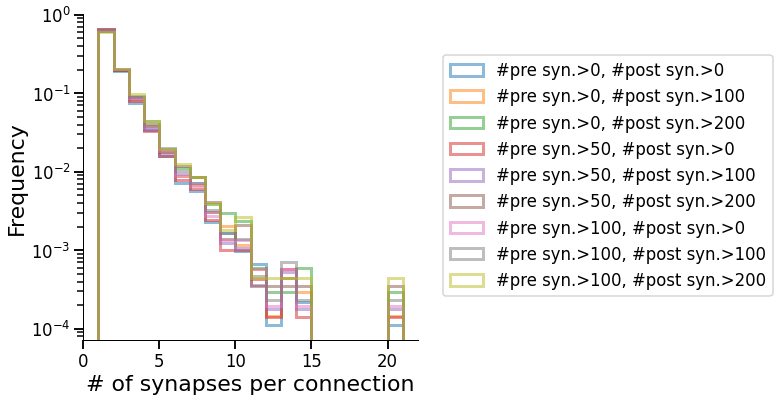

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
for i, ues in enumerate(u_edge_syns):
    sns.distplot(ues, kde=False, ax=ax, bins=np.linspace(1,21,21), label=center_name[i],
                 hist_kws={"histtype": "step", "linewidth": 3, "alpha": 0.5, "density":True})
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05,0.9))
plt.ylabel("Frequency", fontsize=22)
plt.xlabel("# of synapses per connection", fontsize=22)
plt.savefig("figures/paper/syn-dist-log.pdf", 
            bbox_inches='tight')

In [285]:
sum(u.ep["#synapses"].a)

9471

In [284]:
sum(u.ep["#synapses"].a==2) / u.num_edges()

0.19643175735950044

In [286]:
sum(u.ep["#synapses"].a==1)

3603

In [610]:
uesize_list = u.new_edge_property("vector<int32_t>")

for e in u.edges():
    preid = u.vp["cellid"][e.source()]
    postid = u.vp["cellid"][e.target()]
    mask = (all_synapses["presyn_segid"] == preid) & (all_synapses["postsyn_segid"] == postid)
    uesize_list[e] = np.array(all_synapses["size"][mask] / 200).astype(int)

In [679]:
weak_sizes = np.concatenate([uesize_list[e] for e in u.edges() if u.ep['#synapses'][e] == 1])
strong_sizes = np.concatenate([uesize_list[e] for e in u.edges() if u.ep['#synapses'][e] >= 2])

In [647]:
size_count_dict = np.concatenate([list(zip(uesize_list[e], [u.ep['#synapses'][e]]*len(uesize_list[e]))) 
                                  for e in u.edges()])

In [664]:
# check large single-synapse connection
large_weak = []
for e in u.edges():
    if u.ep['#synapses'][e] == 1:
        if u.ep['synapse_size'][e] > 50:
            large_weak.append((u.vp['cellid'][e.source()], u.vp['cellid'][e.target()]))

Text(0.5, 0, 'Synapse sizes')

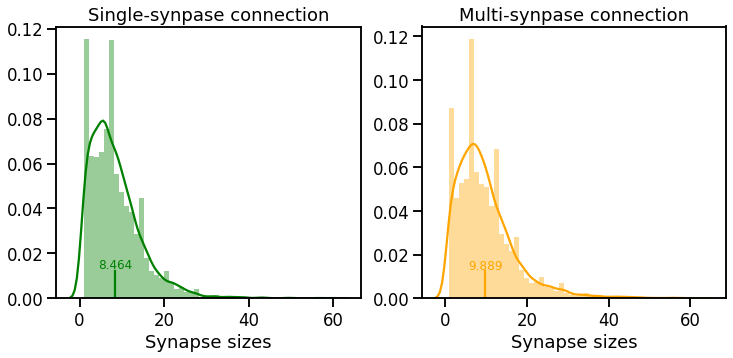

In [680]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.distplot(weak_sizes, ax=ax[0], color='green')
ax[0].axvline(np.mean(weak_sizes), 0, 0.1, color='green')
ax[0].text(np.mean(weak_sizes), 0.015, "{:.3f}".format(np.mean(weak_sizes)),
                       ha="center", va="center", fontsize=12, color='green')

sns.distplot(strong_sizes, ax=ax[1], color='orange')
ax[1].axvline(np.mean(strong_sizes), 0, 0.1, color='orange')
ax[1].text(np.mean(strong_sizes), 0.015, "{:.3f}".format(np.mean(strong_sizes)),
                       ha="center", va="center", fontsize=12, color='orange')

ax[0].set_title("Single-synpase connection")
ax[1].set_title("Multi-synpase connection")
ax[0].set_xlabel("Synapse sizes")
ax[1].set_xlabel("Synapse sizes")

In [681]:
len(weak_sizes), len(strong_sizes)

(3603, 5868)

In [682]:
from scipy import stats
stats.ks_2samp(weak_sizes, strong_sizes)

KstestResult(statistic=0.08792022893896077, pvalue=1.841403757203092e-15)

In [683]:
stats.ks_2samp(weak_sizes, strong_sizes, 'less')

KstestResult(statistic=0.0, pvalue=1.0)

In [578]:
avg_syn_size = u.ep['synapse_size'].a / u.ep['#synapses'].a
syn_size = u.ep['synapse_size'].a
syn_count = u.ep['#synapses'].a

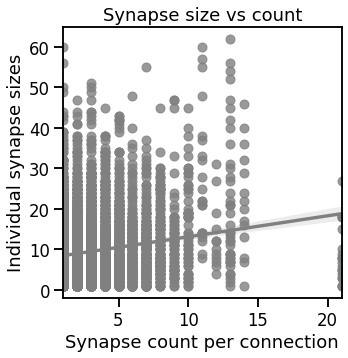

(0.028967664468231853, 9.346637102734663)

In [654]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(size_count_dict[:,1], size_count_dict[:,0],color='gray')
ax.set_title("Synapse size vs count")
ax.set_xlabel("Synapse count per connection")
ax.set_ylabel("Individual synapse sizes")
plt.show()

r2(size_count_dict[:,1], size_count_dict[:,0]), size_count_dict[:,0].mean()

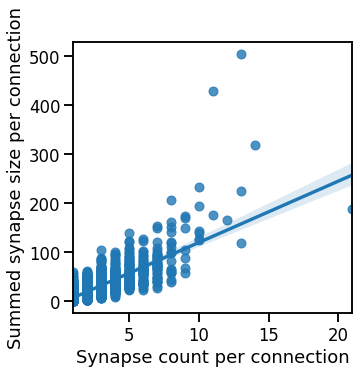

(0.6361579428092032, PropertyArray(8.93598803))

In [648]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(syn_count, syn_size)
ax.set_xlabel("Synapse count per connection")
ax.set_ylabel("Summed synapse size per connection")
plt.show()

r2(syn_count, syn_size), avg_syn_size.mean()

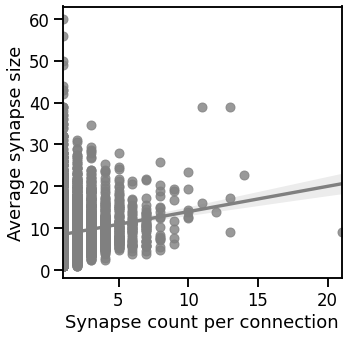

(0.018588075226221416, PropertyArray(8.93598803))

In [579]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(syn_count, avg_syn_size, color='gray')
ax.set_xlabel("Synapse count per connection")
ax.set_ylabel("Average synapse size")
plt.show()

r2(syn_count, avg_syn_size), avg_syn_size.mean()

### 7. Integration from all saved figures

In [21]:
modO = gt.load_graph("saved/gt-ax50-dd100-modO-sg.xml.gz")

In [20]:
modA = gt.load_graph("saved/gt-ax50-dd100-modA-sg.xml.gz")

In [120]:
g_old = gt.load_graph("saved/whole-label-ax50-dd100.xml.gz")

In [121]:
g_old

<Graph object, directed, with 2820 vertices and 44312 edges, 24 internal vertex properties, 2 internal edge properties, at 0x7f057470cf28>

In [122]:
def trans_vp_from_old(vp_name, vp_type, notfoundvalue):
    trans_dict = {g_old.vp["cellid"][v]:g_old.vp[vp_name][v] 
                  for v in g_old.vertices()}
    new_vp = g.new_vertex_property(vp_type)
    for v in g.vertices():
        cid = g.vp["cellid"][v]
        if cid in trans_dict.keys():
            new_vp[v] = trans_dict[cid]
        else:
            new_vp[v] = notfoundvalue
    g.vp[vp_name] = new_vp

In [123]:
trans_vp_from_old("center", "bool", notfoundvalue=False)
trans_vp_from_old("large_rs", "bool", notfoundvalue=False)
trans_vp_from_old("modO_sg", "bool", notfoundvalue=False)
trans_vp_from_old("modO_sg_sbm", "int32_t", notfoundvalue=-1)
trans_vp_from_old("peripheral", "int32_t", notfoundvalue=1) # -1 other, 0 source, 1 sink
for k in g_old.vp.keys():
    if k[:3] == 'sbm':
        trans_vp_from_old(k, "int32_t", notfoundvalue=-1)

In [124]:
g

<Graph object, directed, with 2824 vertices and 44969 edges, 24 internal vertex properties, 2 internal edge properties, at 0x7f05e314f0f0>

In [125]:
g.save("saved/whole-w-all-abd.xml.gz")

### 8. Plot block structures
(stats are in the original `Combined....ipynb`)

In [126]:
gen_mask = lambda x: np.array(x, dtype="bool")

In [127]:
def validate_syn_prob(g, sbm_name, weight='#synapses', norm=True, RS=False):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge source neurons
    mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 0)]
    fv = mclass[0]
    # print("source", fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != fv:
            merge_g.merge_vertices(v, fv)

    # merge sink-non-abd neurons
    if RS:
        mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['large_rs'].a == True))]
    else:
        mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a != 14) &
                                       (m.vp['celltype'].a != 15))]
    non_abd_fv = mclass[0]
    # print("sink-non-abd", non_abd_fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != non_abd_fv:
            merge_g.merge_vertices(v, non_abd_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                   ((m.vp['celltype'].a == 14) |
                                   (m.vp['celltype'].a == 15)))]
    abd_fv = mclass[0]
    # print("sink-abd", abd_fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abd_fv:
            merge_g.merge_vertices(v, abd_fv)

    # merge scc-0 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 0)]
    center_fv0 = mclass[0]
    # print("center-0", center_fv0)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv0:
            merge_g.merge_vertices(v, center_fv0)

    # merge scc-1 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 1)]
    center_fv1 = mclass[0]
    # print("center-1", center_fv1)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv1:
            merge_g.merge_vertices(v, center_fv1)

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[[abd_fv,abd_fv,non_abd_fv,non_abd_fv],
                        [center_fv0,center_fv1,center_fv0,center_fv1]].reshape(2,2)
    
    syn_prob_block = A_mg[[center_fv0,center_fv0,center_fv1,center_fv1],
                        [center_fv0,center_fv1,center_fv0,center_fv1]].reshape(2,2)

    return syn_prob_abd, syn_prob_block

In [174]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg_nd', 'mg_c', 'sg', 'wc_c', 'sc_c']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob(g, "sbm_{}".format(k),  weight='#synapses', norm=True, RS=True)

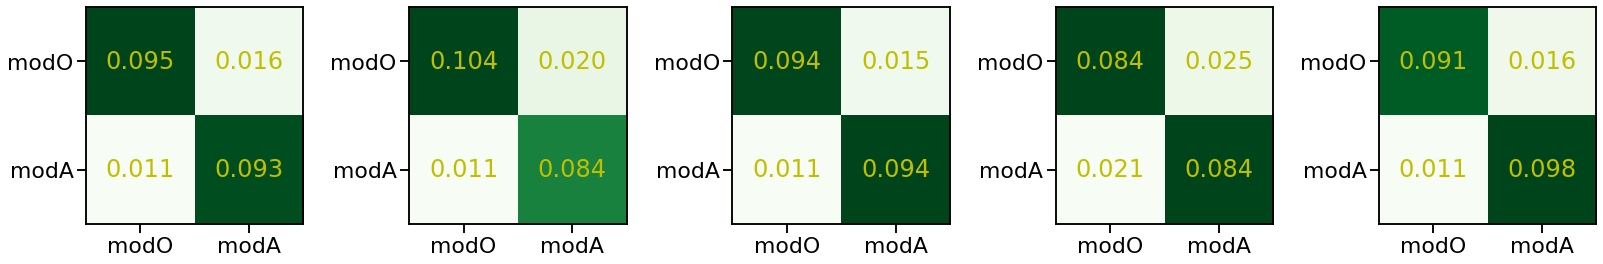

In [175]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block[k], cmap="Greens")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_block[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)

plt.savefig("figures/paper/n-sc-OvsA.pdf", 
            bbox_inches='tight')

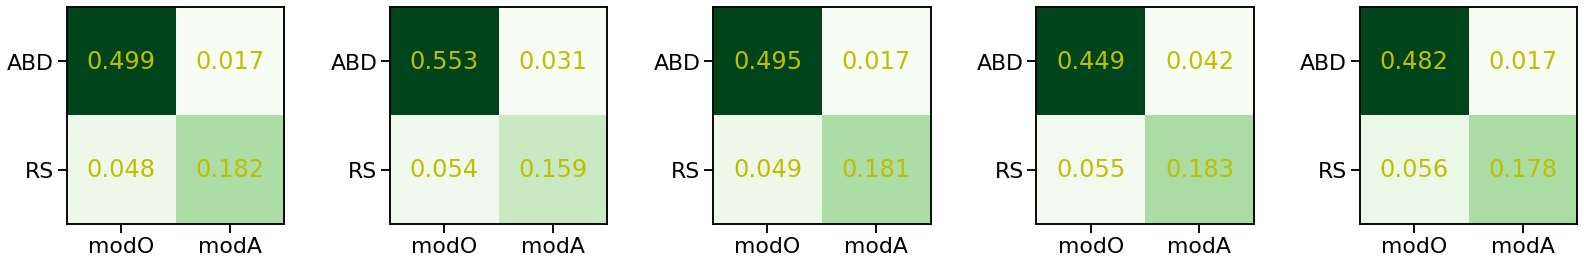

In [176]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd[k], cmap="Greens")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_abd[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/n-sc-ABDvsRS.pdf", 
            bbox_inches='tight')

In [177]:
syn_prob_abd_sc, syn_prob_block_sc = {}, {}
names = ['sg_nd', 'mg_c', 'sg', 'wc_c', 'sc_c']
for k in names:
    syn_prob_abd_sc[k], syn_prob_block_sc[k] = validate_syn_prob(g, "sbm_{}".format(k),  weight=False, RS=True)

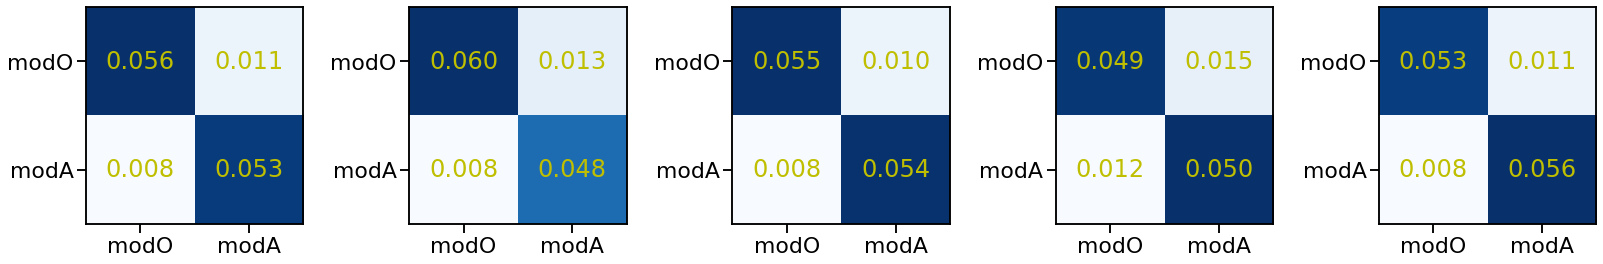

In [178]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block_sc[k], cmap="Blues")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_block_sc[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)
    
plt.savefig("figures/paper/n-c-OvsA.pdf", 
            bbox_inches='tight')

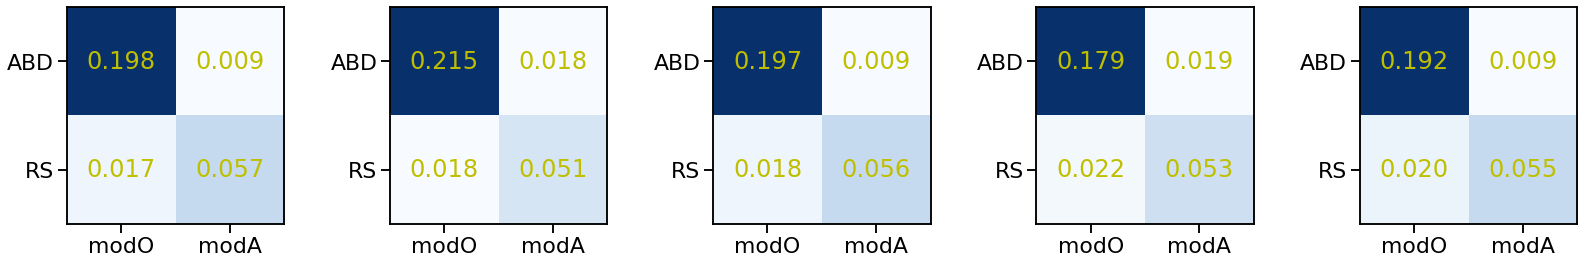

In [179]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd_sc[k], cmap="Blues")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_abd_sc[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/n-c-ABDvsRS.pdf", 
            bbox_inches='tight')

In [171]:
syn_prob_abd_ss, syn_prob_block_ss = {}, {}
names = ['sg_nd', 'mg_c', 'sg', 'wc_c', 'sc_c']
for k in names:
    syn_prob_abd_ss[k], syn_prob_block_ss[k] = validate_syn_prob(g, "sbm_{}".format(k),  weight='synapse_size', norm=True, RS=True)

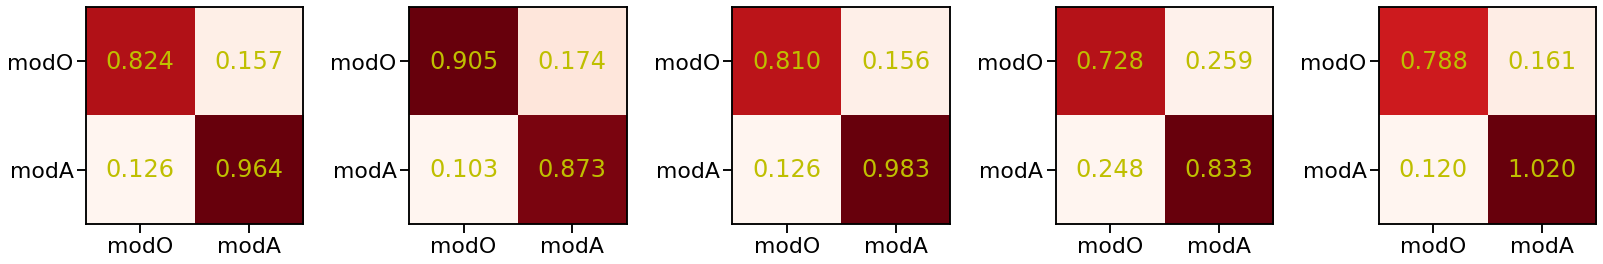

In [172]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block_ss[k], cmap="Reds")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_block_ss[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)

plt.savefig("figures/paper/n-ss-OvsA.pdf", 
            bbox_inches='tight')

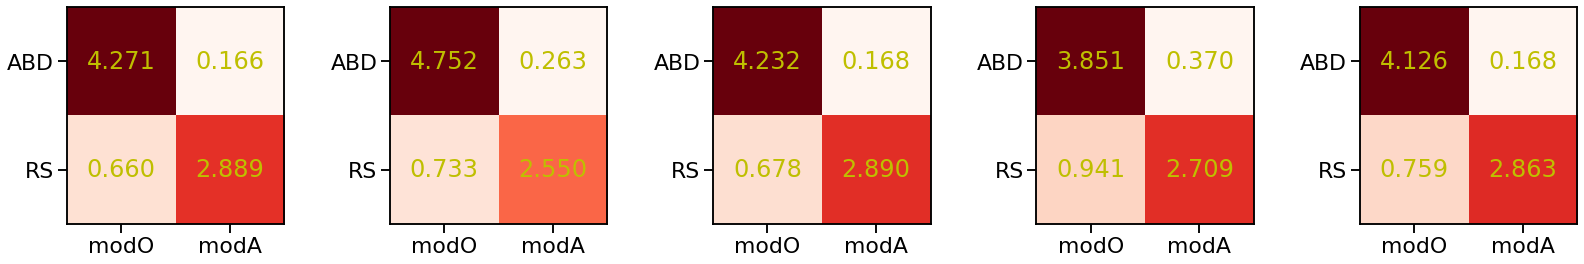

In [173]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd_ss[k], cmap="Reds")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_abd_ss[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/n-ss-ABDvsRS.pdf", 
            bbox_inches='tight')

In [159]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg_nd', 'mg_c', 'sg', 'wc_c', 'sc_c']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob(g, "sbm_{}".format(k),  weight='#synapses', norm=False, RS=True)

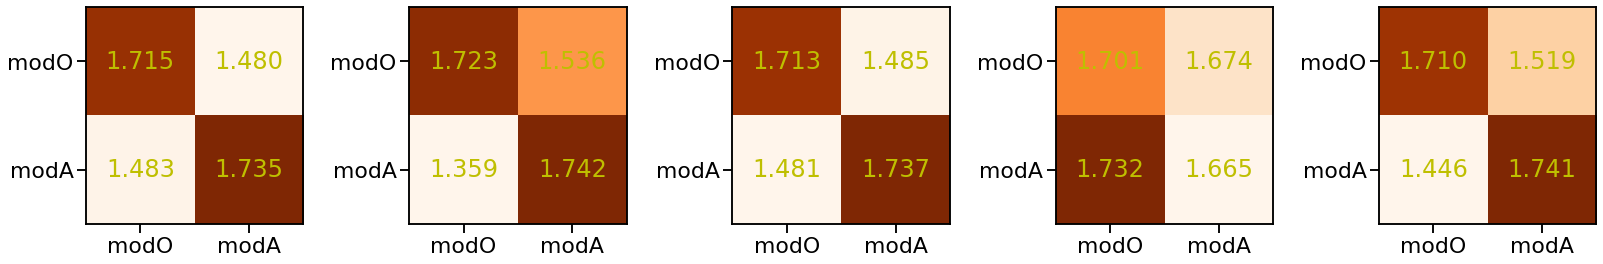

In [180]:
eps = 1e-10
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block[k] / (syn_prob_block_sc[k] + eps), cmap="Oranges")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_block[k][i, j] / (syn_prob_block_sc[k][i, j] + eps)),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)
    
plt.savefig("figures/paper/sc-c-OvsA.pdf", 
            bbox_inches='tight')

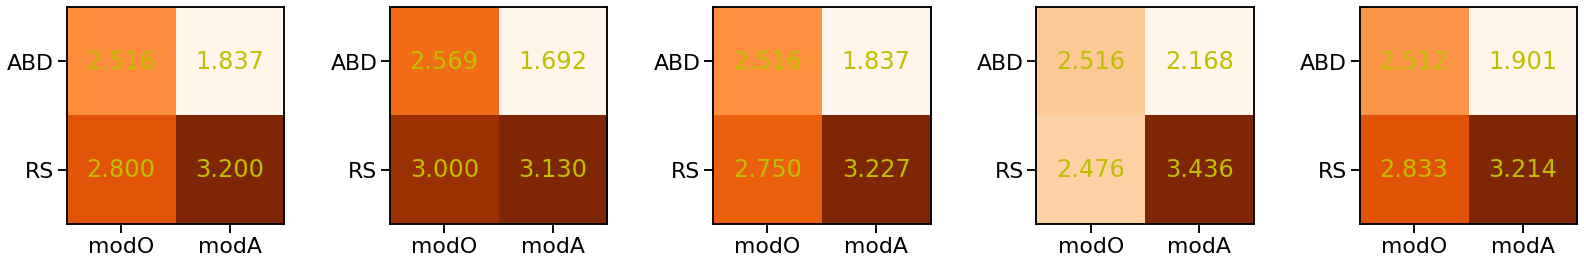

In [181]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd[k] / (syn_prob_abd_sc[k] + eps), cmap="Oranges")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_abd[k][i, j] / (syn_prob_abd_sc[k][i, j] + eps)),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/sc-c-ABDvsRS.pdf", 
            bbox_inches='tight')

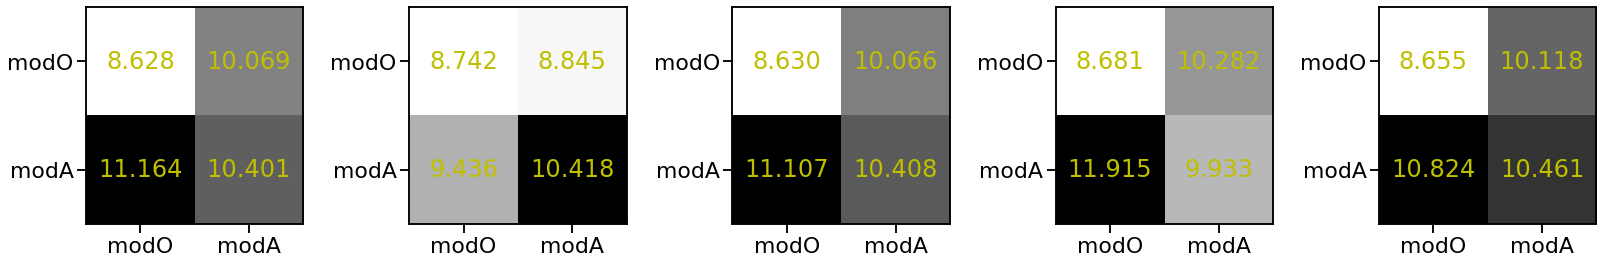

In [188]:
eps = 1e-10
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block_ss[k] / (syn_prob_block[k] + eps), cmap="Greys")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_block_ss[k][i, j] / (syn_prob_block[k][i, j] + eps)),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)
    
plt.savefig("figures/paper/ss-sc-OvsA.pdf", 
            bbox_inches='tight')

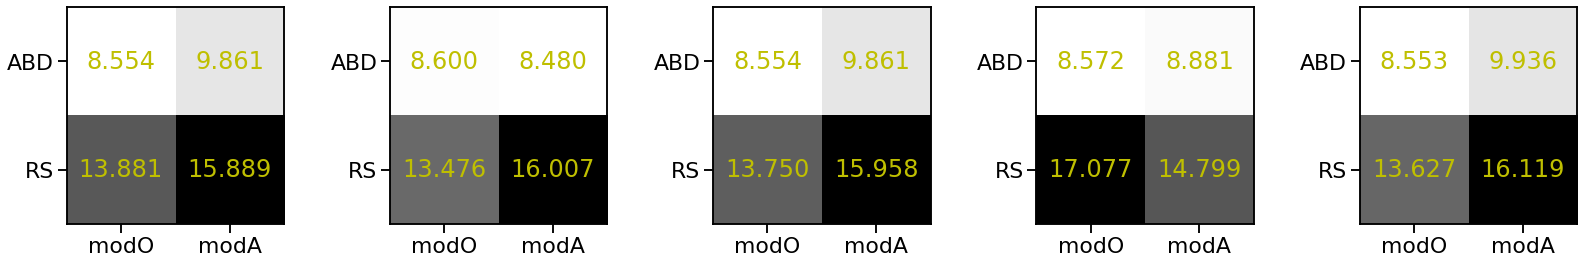

In [189]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd_ss[k] / (syn_prob_abd[k] + eps), cmap="Greys")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_abd_ss[k][i, j] / (syn_prob_abd[k][i, j] + eps)),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/ss-sc-ABDvsRS.pdf", 
            bbox_inches='tight')

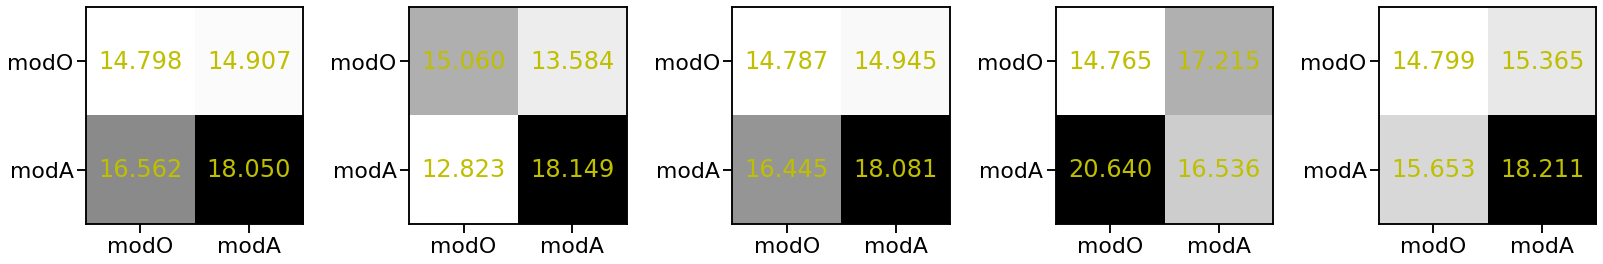

In [190]:
eps = 1e-10
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block_ss[k] / (syn_prob_block_sc[k] + eps), cmap="Greys")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_block_ss[k][i, j] / (syn_prob_block_sc[k][i, j] + eps)),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)
    
plt.savefig("figures/paper/ss-c-OvsA.pdf", 
            bbox_inches='tight')

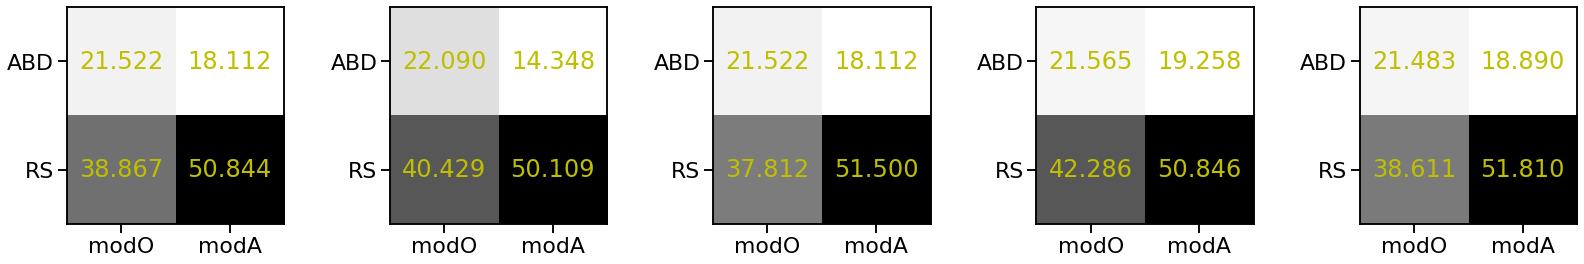

In [193]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd_ss[k] / (syn_prob_abd_sc[k] + eps), cmap="Greys")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.3f}".format(syn_prob_abd_ss[k][i, j] / (syn_prob_abd_sc[k][i, j] + eps)),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/ss-c-ABDvsRS.pdf", 
            bbox_inches='tight')

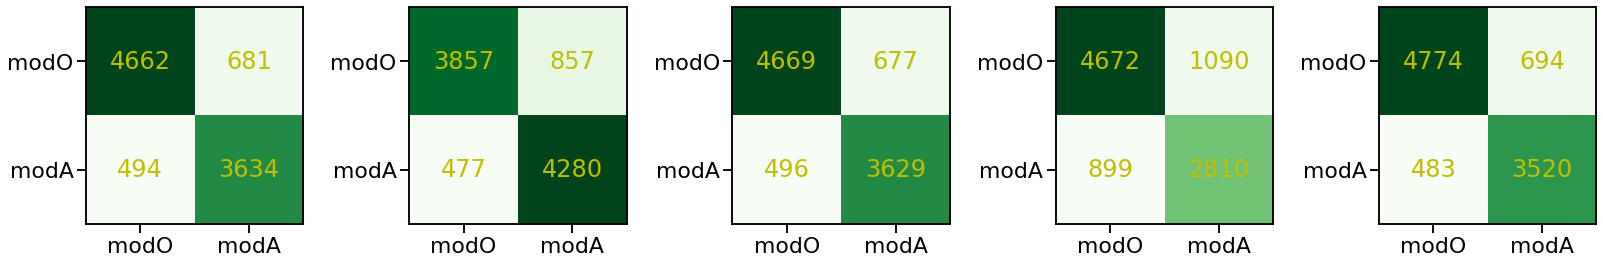

In [160]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block[k], cmap="Greens")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.0f}".format(syn_prob_block[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)

plt.savefig("figures/paper/nx-sc-OvsA.pdf", 
            bbox_inches='tight')

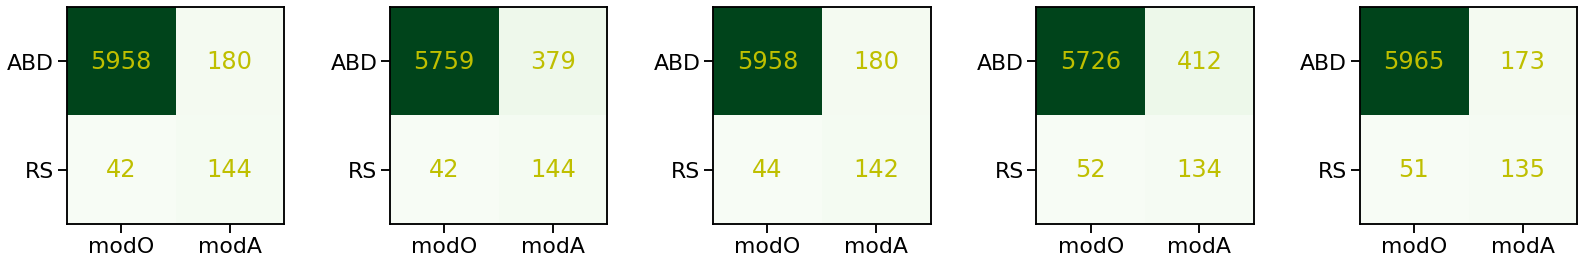

In [161]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd[k], cmap="Greens")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.0f}".format(syn_prob_abd[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/nx-sc-ABDvsRS.pdf", 
            bbox_inches='tight')

In [162]:
syn_prob_abd_sc, syn_prob_block_sc = {}, {}
names = ['sg_nd', 'mg_c', 'sg', 'wc_c', 'sc_c']
for k in names:
    syn_prob_abd_sc[k], syn_prob_block_sc[k] = validate_syn_prob(g, "sbm_{}".format(k), weight=False, norm=False, RS=True)

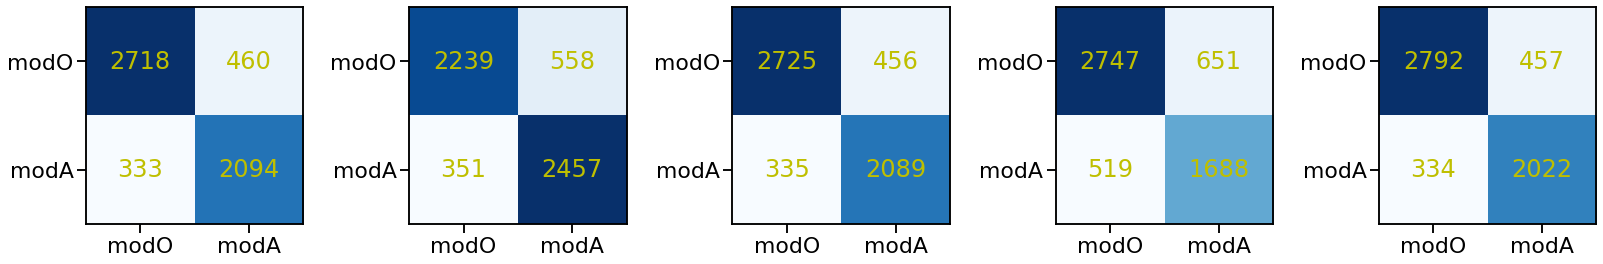

In [163]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_block_sc[k], cmap="Blues")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.0f}".format(syn_prob_block_sc[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["modO", "modA"], fontsize=22)
    
plt.savefig("figures/paper/nx-c-OvsA.pdf", 
            bbox_inches='tight')

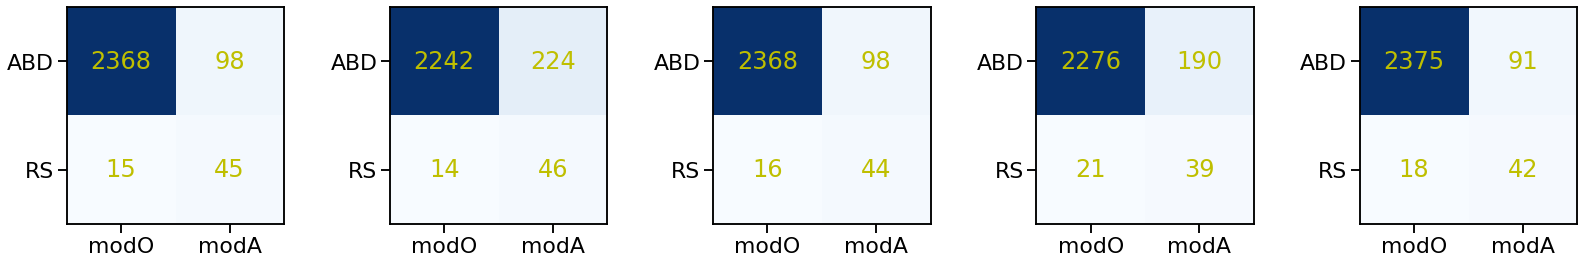

In [164]:
fig, axs = plt.subplots(1,5, figsize=(28,4))
for ax, k in zip(axs, names):
    ax.imshow(syn_prob_abd_sc[k], cmap="Blues")

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, "{:.0f}".format(syn_prob_abd_sc[k][i, j]),
                           ha="center", va="center", color="y", fontsize=24)
    ax.set_xticks(range(2))
    ax.set_xticklabels(["modO", "modA"], fontsize=22)
    ax.set_yticks(range(2))
    ax.set_yticklabels(["ABD", "RS"], fontsize=22)
    
plt.savefig("figures/paper/nx-c-ABDvsRS.pdf", 
            bbox_inches='tight')

### 9. Plot large block structures
(stats are in the original `Combined....ipynb`)

In [216]:
A_g = gt.adjacency(g, weight=g.ep["#synapses"]).todense()
A_g = np.array(A_g)

In [217]:
block1_ids = np.arange(len(A_g))[g.vp["sbm_sg"].a == 0]
block2_ids = np.arange(len(A_g))[g.vp["sbm_sg"].a == 1]

# get_order = lambda ids: np.argsort(np.array(list(zip(A_g[ids][:,ids].sum(0), A_g[ids][:,ids].sum(1))), 
#                                             dtype=[('x', '<i4'), ('y', '<i4')]), order=('x', 'y'))[::-1]
get_order = lambda ids: np.argsort(np.array(list(A_g[ids][:,ids].sum(0) + A_g[ids][:,ids].sum(1))))[::-1]

block1_ids = list(block1_ids[get_order(block1_ids)])
block2_ids = list(block2_ids[get_order(block2_ids)])

A_blocks = np.minimum(A_g[block1_ids + block2_ids][:,block1_ids + block2_ids], 5)

In [218]:
import matplotlib as mpl
from matplotlib import colors

cmap = plt.cm.get_cmap('rainbow', 6)  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (1, 1, 1, 0.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

In [553]:
rand_ids = np.random.permutation(block1_ids + block2_ids)
A_rand = np.minimum(A_g[rand_ids][:,rand_ids], 5)

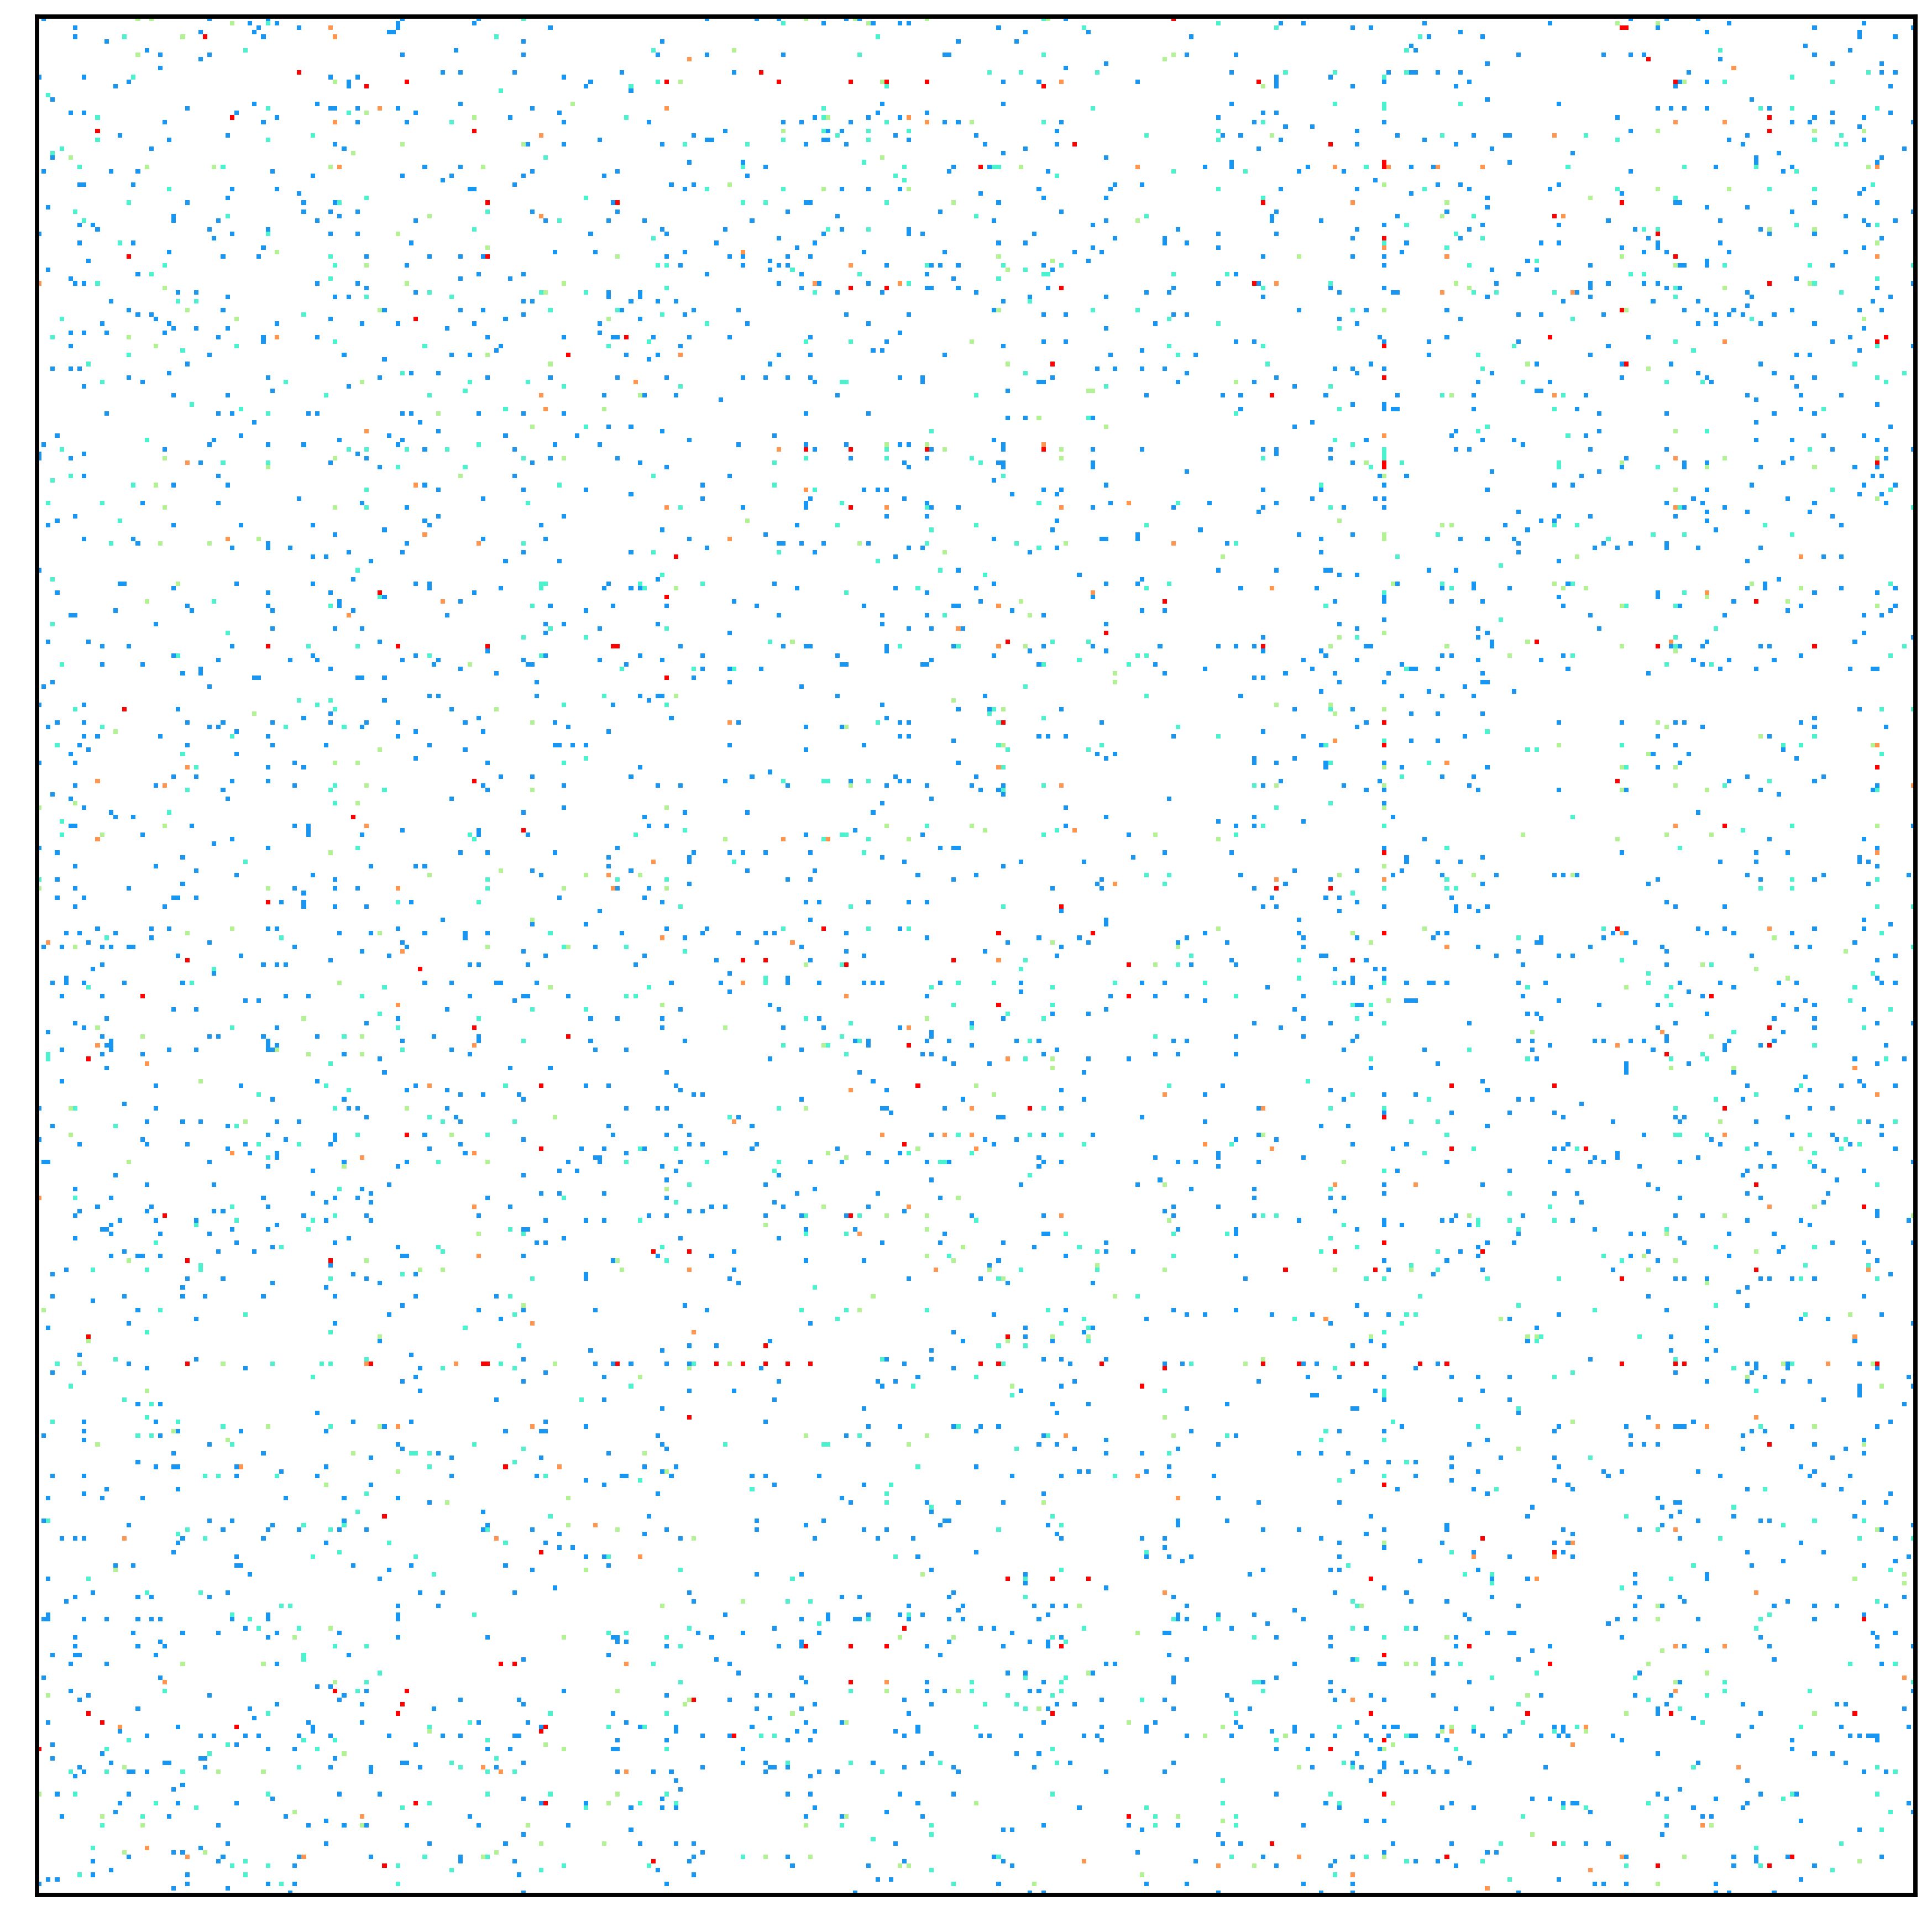

In [555]:
fig, ax = plt.subplots(figsize=(20,15), dpi=300)
norm = colors.BoundaryNorm(np.arange(-0.5, 6, 1), cmap.N)
labels = np.array(["0", "1", "2", "3", "4", "≥5"])
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[x])

blocks_im = ax.imshow(A_rand, cmap=cmap, norm=norm)
ax = plt.gca();

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.grid(which='major', color='k', linestyle='-', linewidth=0.5)
# cbar = plt.colorbar(blocks_im, ticks=np.arange(1, 6), format=fmt, orientation="horizontal")
# for t in cbar.ax.get_xticklabels():
#      t.set_fontsize(42)
plt.savefig("figures/paper/original-matrix.pdf", 
            bbox_inches='tight')

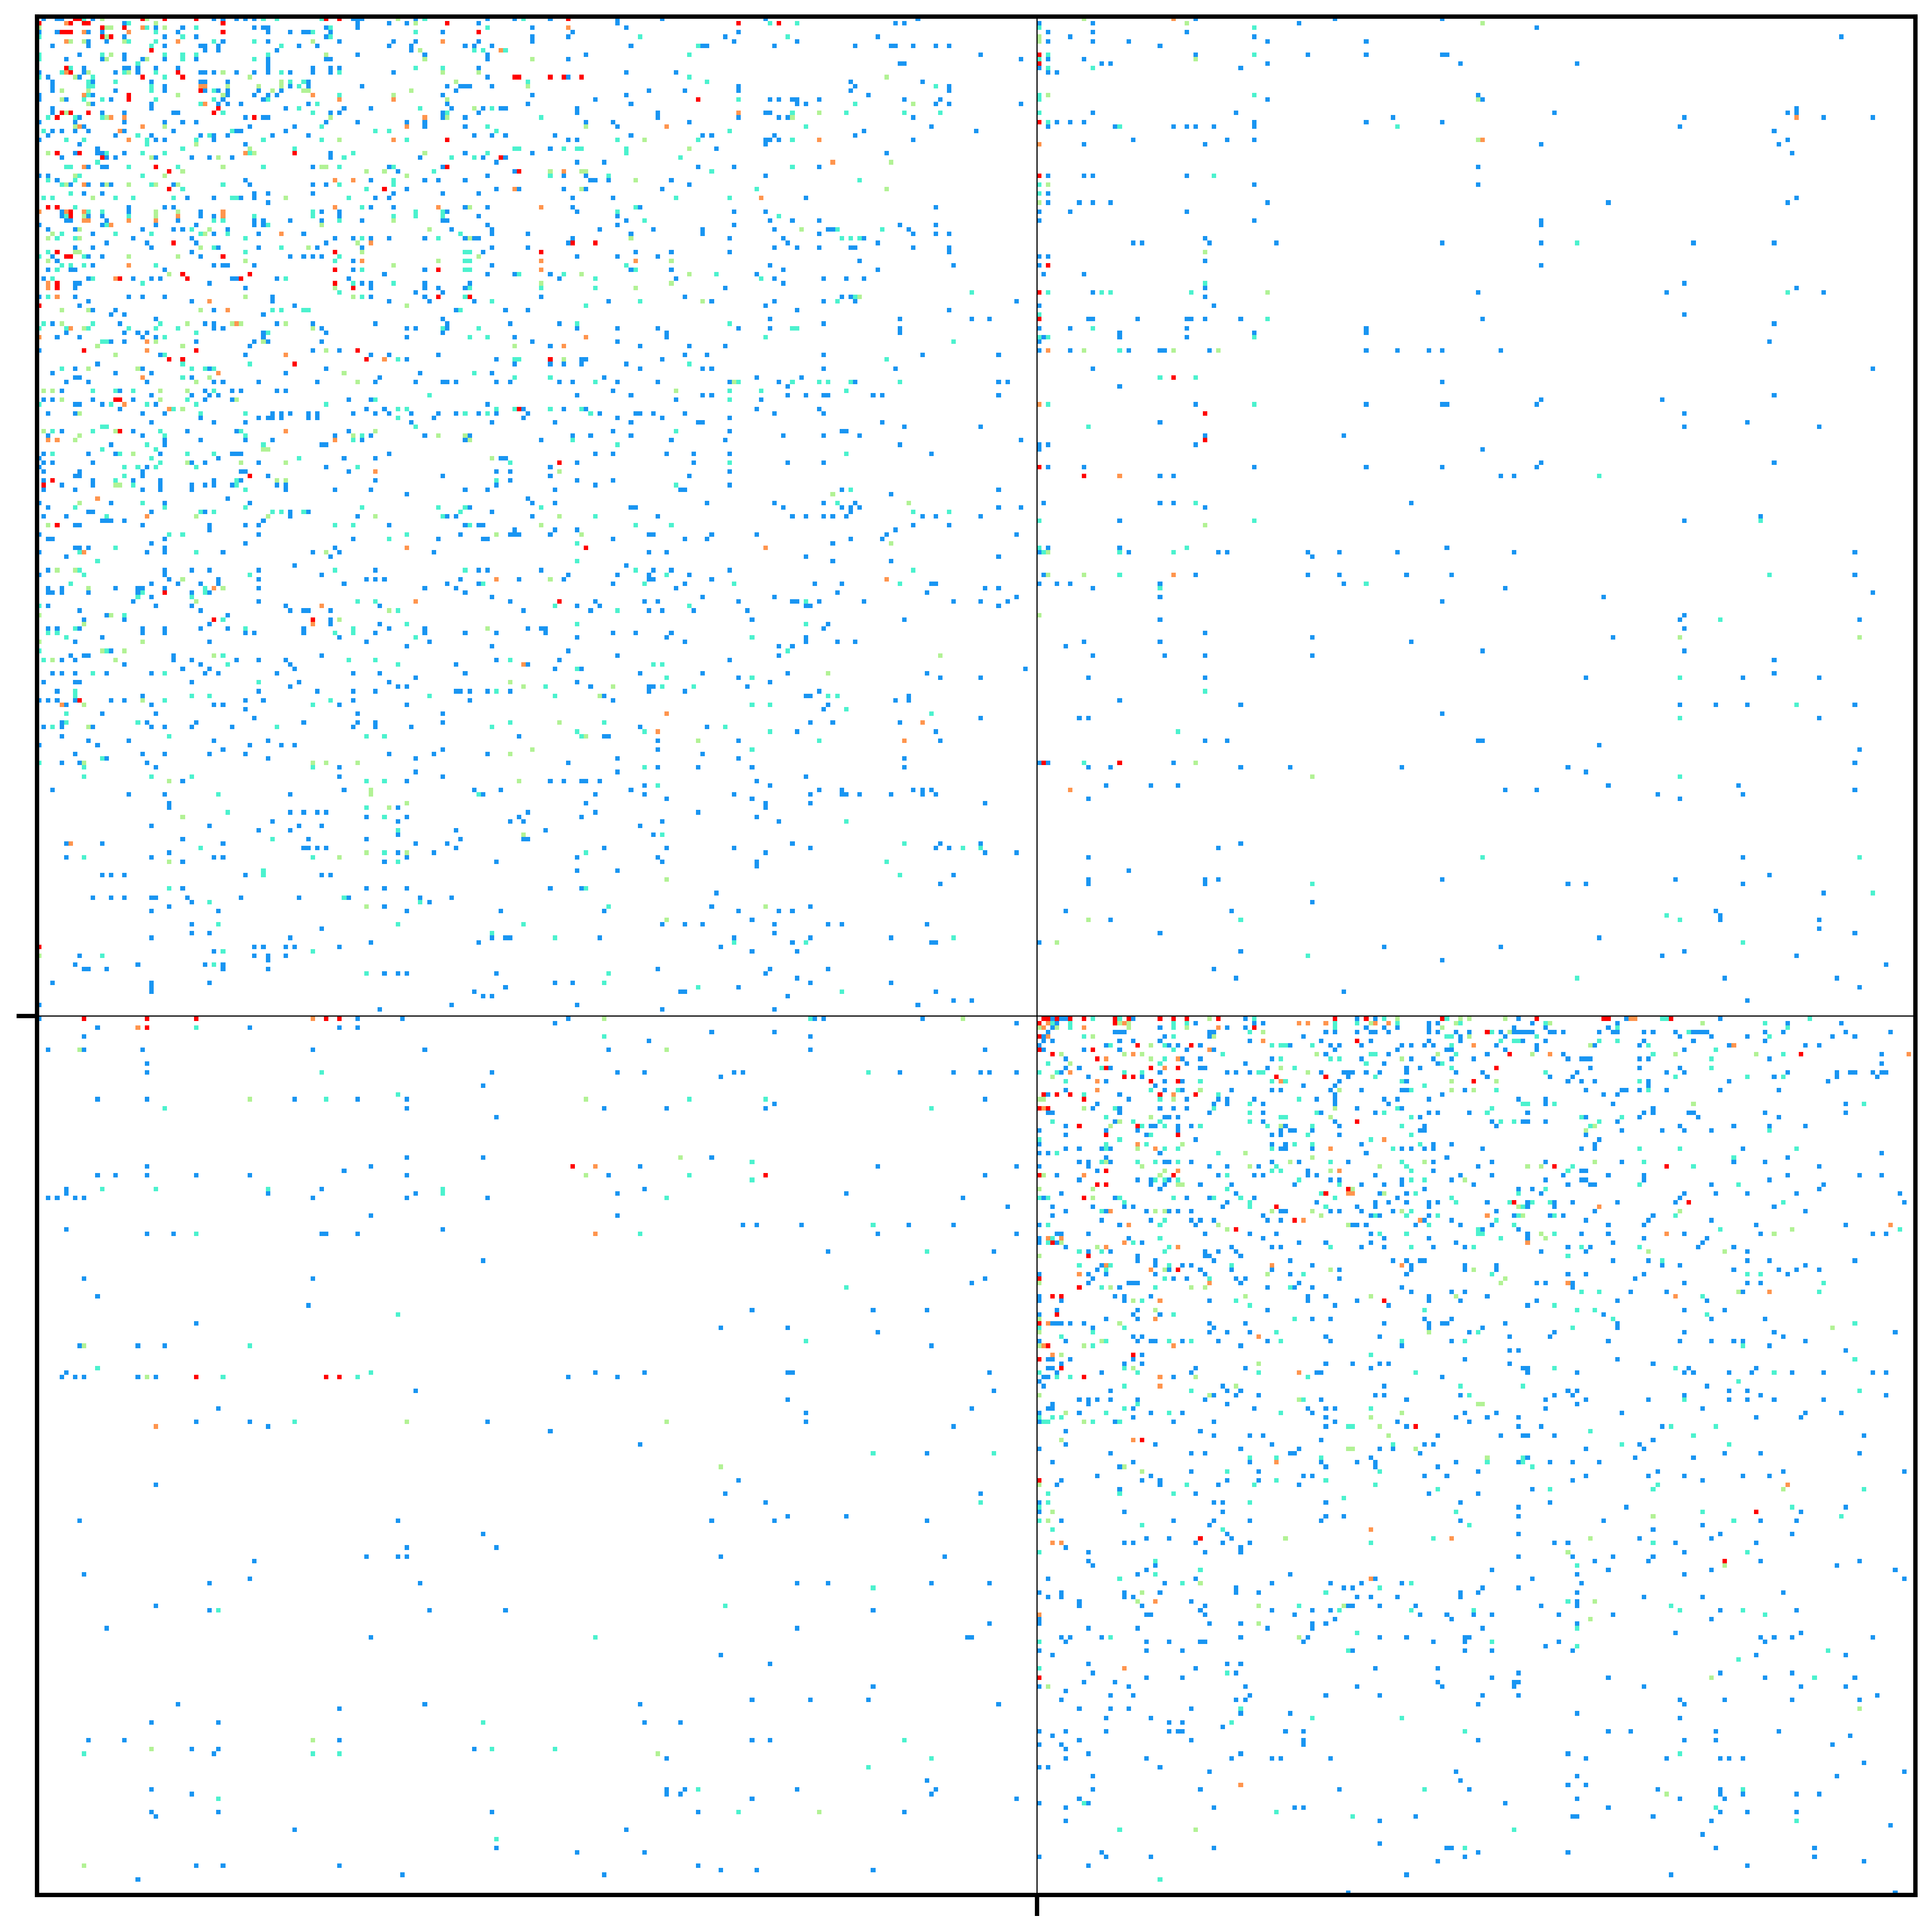

In [219]:
fig, ax = plt.subplots(figsize=(20,15), dpi=300)
norm = colors.BoundaryNorm(np.arange(-0.5, 6, 1), cmap.N)
labels = np.array(["0", "1", "2", "3", "4", "≥5"])
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[x])

blocks_im = ax.imshow(A_blocks, cmap=cmap, norm=norm)
ax = plt.gca();

ax.set_xticks([len(block1_ids)-0.5])
ax.set_yticks([len(block1_ids)-0.5])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.grid(which='major', color='k', linestyle='-', linewidth=0.5)
# cbar = plt.colorbar(blocks_im, ticks=np.arange(1, 6), format=fmt, orientation="horizontal")
# for t in cbar.ax.get_xticklabels():
#      t.set_fontsize(42)
plt.savefig("figures/paper/modOvsmodAmatrix.pdf", 
            bbox_inches='tight')

In [220]:
block1_ids = np.arange(len(A_g))[g.vp["sbm_sg"].a == 0]
block2_ids = np.arange(len(A_g))[g.vp["sbm_sg"].a == 1]
abd_ids = np.arange(len(A_g))[[v in [14, 15] for v in g.vp["celltype"].a]] 
rs_ids = np.arange(len(A_g))[[g.vp["large_rs"][v] == True for v in g.vertices()]]

# get_order = lambda ids: np.argsort(np.array(list(zip(A_g[ids][:,ids].sum(0), A_g[ids][:,ids].sum(1))), 
#                                             dtype=[('x', '<i4'), ('y', '<i4')]), order=('x', 'y'))[::-1]
get_order = lambda ids: np.argsort(np.array(list(A_g[ids][:,ids].sum(0) + A_g[ids][:,ids].sum(1))))[::-1]

block1_ids = list(block1_ids[get_order(block1_ids)])
block2_ids = list(block2_ids[get_order(block2_ids)])
abd_ids = list(abd_ids)
rs_ids = list(rs_ids)

A_blocks = np.minimum(A_g[abd_ids + rs_ids][:,block1_ids + block2_ids], 5)

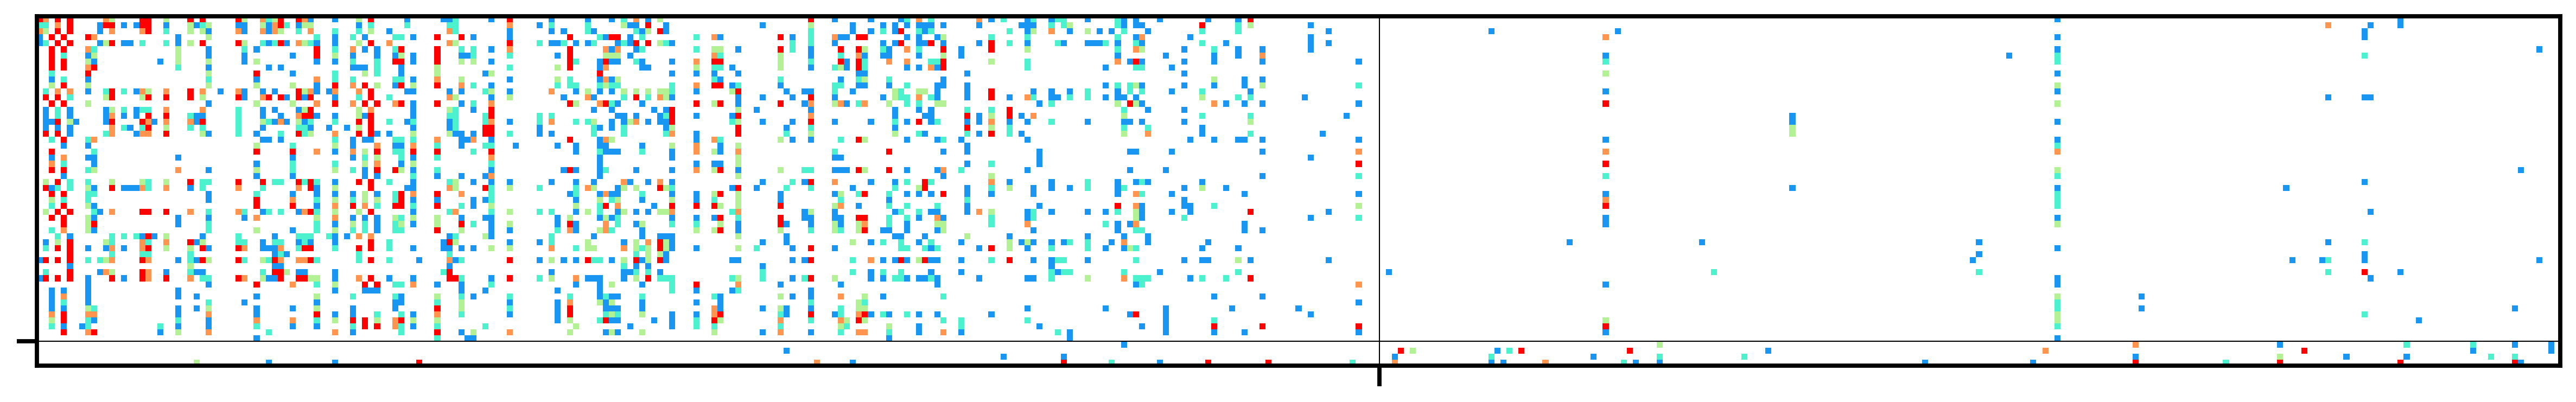

In [221]:
fig, ax = plt.subplots(figsize=(20,15), dpi=300)
norm = colors.BoundaryNorm(np.arange(-0.5, 6, 1), cmap.N)
labels = np.array(["0", "1", "2", "3", "4", "≥5"])
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[x])

blocks_im = ax.imshow(A_blocks, cmap=cmap, norm=norm)
ax = plt.gca();

ax.set_xticks([len(block1_ids)-0.5])
ax.set_yticks([len(abd_ids)-0.5])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.grid(which='major', color='k', linestyle='-', linewidth=0.5)
plt.savefig("figures/paper/ABDvsRSmatrix.pdf", 
            bbox_inches='tight')

## 10. Plot strong vs waek connections

In [236]:
u = gt.load_graph("saved/gt-ax50-dd100.xml.gz")
u

<Graph object, directed, with 419 vertices and 5605 edges, 18 internal vertex properties, 2 internal edge properties, at 0x7f0571bd3710>

In [237]:
u_edge_syn_s = np.array([u.ep["synapse_size"][e] for e in u.edges()])
u_edge_syn_c = np.array([u.ep["#synapses"][e] for e in u.edges()])

In [238]:
def get_weak_subgraph(u, threshold=1, weight='#synapses'):
    weak_tie_filter = u.new_edge_property("bool")
    for i, e in enumerate(u.edges()):
        weak_tie_filter[e] = u.ep[weight][e] <= threshold

    wu = u.copy()
    wu.set_edge_filter(weak_tie_filter)
    wu = gt.Graph(wu, prune=True)
    return wu

def get_strong_subgraph(u, threshold=1, weight='#synapses'):
    strong_tie_filter = u.new_edge_property("bool")
    for i, e in enumerate(u.edges()):
        strong_tie_filter[e] = u.ep[weight][e] >= threshold

    su = u.copy()
    su.set_edge_filter(strong_tie_filter)
    su = gt.Graph(su, prune=True)
    return su

In [246]:
import pyintergraph
import networkx.algorithms.community as nx_comm

def overall_stats(overall, ths_names,
                   xlabel='Weighted modularity Q',
                   ylabel='Synapse size threshold',
                   verbose=True,
                   yrange=None,
                   save=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.bar(ths_names, overall, alpha=0.5, color='gray')
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    if verbose:
        for i, v in enumerate(overall):
            ax.text(i-0.25, v * 1.07, "{:.2f}".format(v), color='gray', fontsize=16)
            ax.text(i-0.32, v * 1.01, "(x{:.2f})".format(v/overall[0]), color='gray', fontsize=12)
    if yrange:
        plt.ylim(yrange)
        
    if save:
        plt.savefig("figures/paper/{}.pdf".format(save), bbox_inches='tight')

In [241]:
def intra_community_strength(u, partition, weight='#synapses'):
    return sum(u.subgraph(block).size(weight=weight) 
               for block in partition)

def inter_community_strength(u, partition, weight='#synapses'):
    MG = nx.MultiDiGraph if u.is_directed() else nx.MultiGraph
    return nx.quotient_graph(u, partition, create_using=MG).size(weight=weight)

def coverage(u, communities, weight='#synapses'):
    u_nx = pyintergraph.gt2nx(u)
    intra = intra_community_strength(u_nx, communities, weight=weight)
    inter = inter_community_strength(u_nx, communities, weight=weight)
    coverage_rate = intra / (inter+intra)
    return coverage_rate

In [242]:
def ratio(u, communities, weight='#synapses'):
    u_nx = pyintergraph.gt2nx(u)
    intra = intra_community_strength(u_nx, communities, weight=weight)
    inter = inter_community_strength(u_nx, communities, weight=weight)
    if inter == 0:
        inter = 1e-6
        intra = 1
    cov_ratio = intra / inter
    return cov_ratio

In [243]:
u_nx = pyintergraph.gt2nx(u)
communities = [[v[0] for v in u_nx.nodes(data=True) if v[1]["sbm_sg"] == mo] for mo in [0, 1]]

In [244]:
modQ_s = []
cov_s = []
rat_s = []

ths = [500, 50, 20, 10, 5, 1]

percentage_ths = ["{:.1f}%".format(100. * sum(u_edge_syn_s <= th) 
                                   / len(u_edge_syn_s)) for th in ths]
ths_names = ["≤"+str(v[0])+'\n('+v[1]+')' for v in zip(ths, percentage_ths)]

for th in ths:
    wu_s = get_weak_subgraph(u, th, weight='synapse_size')
    modQ_s.append(nx_comm.modularity(pyintergraph.gt2nx(wu_s), 
                           communities, weight="synapse_size"))
    cov_s.append(coverage(wu_s, communities, weight="synapse_size"))
    rat_s.append(ratio(wu_s, communities, weight="synapse_size"))

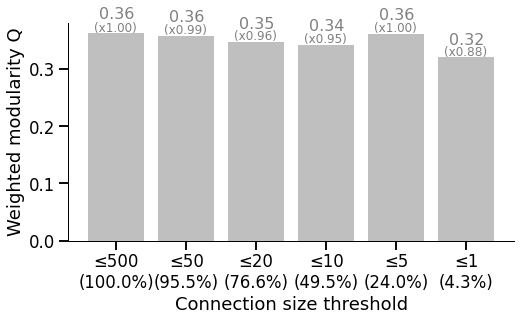

In [247]:
overall_stats(modQ_s, ths_names, ylabel='Connection size threshold', 
              save="mQ-size-remove-strong")

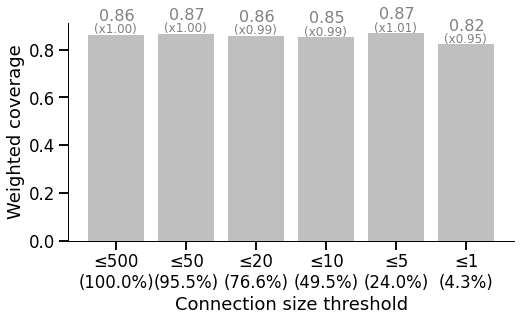

In [248]:
overall_stats(cov_s, ths_names, xlabel='Weighted coverage', ylabel='Connection size threshold', 
              save="wc-size-remove-strong")

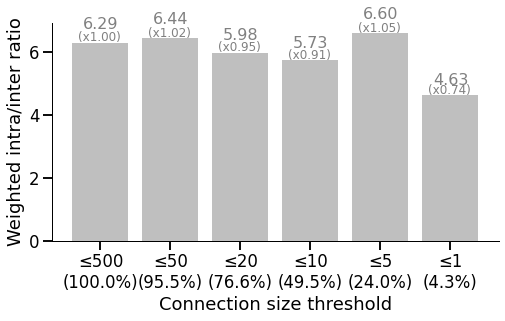

In [249]:
overall_stats(rat_s, ths_names, xlabel='Weighted intra/inter ratio', ylabel='Connection size threshold',
             save="iir-size-remove-strong")

In [257]:
modQ_s = []
cov_s = []
rat_s = []
ths = [1, 2, 5, 10, 20, 50]

percentage_ths = ["{:.1f}%".format(100. * sum(u_edge_syn_s >= th) 
                                   / len(u_edge_syn_s)) for th in ths]
ths_names = ["≥"+str(v[0])+'\n('+v[1]+')' for v in zip(ths, percentage_ths)]

for th in ths:
    su_s = get_strong_subgraph(u, th, weight='synapse_size')
    modQ_s.append(nx_comm.modularity(pyintergraph.gt2nx(su_s), 
                           communities, weight="synapse_size"))
    cov_s.append(coverage(su_s, communities, weight="synapse_size"))
    rat_s.append(ratio(su_s, communities, weight="synapse_size"))

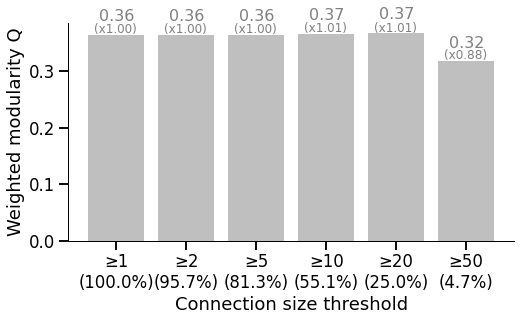

In [258]:
overall_stats(modQ_s, ths_names, ylabel='Connection size threshold', 
              save="mQ-size-remove-weak")

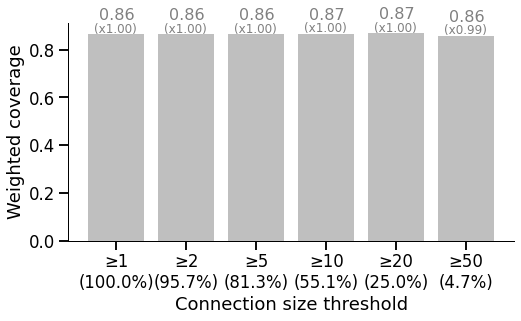

In [259]:
overall_stats(cov_s, ths_names, xlabel='Weighted coverage', ylabel='Connection size threshold', 
              save="wc-size-remove-weak")

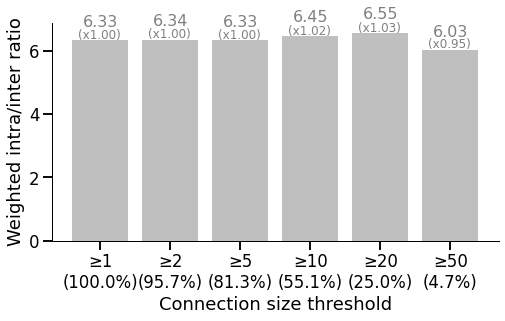

In [260]:
overall_stats(rat_s, ths_names, xlabel='Weighted intra/inter ratio', ylabel='Connection size threshold',
             save="iir-size-remove-weak")

In [261]:
modQ_c = []
cov_c = []
rat_c = []
ths = [20, 10, 5, 3, 2, 1]

percentage_ths = ["{:.1f}%".format(100. * sum(u_edge_syn_c <= th) 
                                   / len(u_edge_syn_c)) for th in ths]
ths_names = ["≤"+str(v[0])+'\n('+v[1]+')' for v in zip(ths, percentage_ths)]

for th in ths:
    wu_c = get_weak_subgraph(u, th, weight='#synapses')
    modQ_c.append(nx_comm.modularity(pyintergraph.gt2nx(wu_c), 
                           communities, weight="#synapses"))
    cov_c.append(coverage(wu_c, communities, weight="#synapses"))
    rat_c.append(ratio(wu_c, communities, weight="#synapses"))

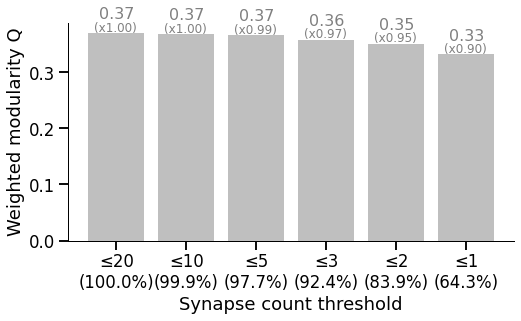

In [262]:
overall_stats(modQ_c, ths_names, ylabel='Synapse count threshold', 
              save="mQ-count-remove-strong")

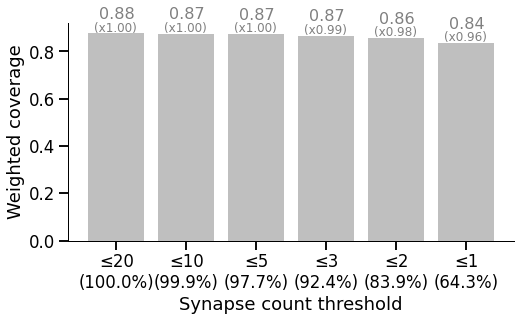

In [263]:
overall_stats(cov_c, ths_names, xlabel='Weighted coverage', ylabel='Synapse count threshold',
             save="wc-count-remove-strong")

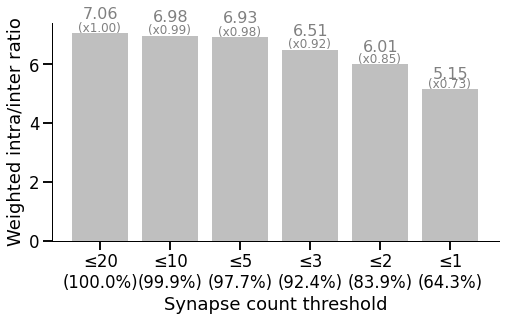

In [264]:
overall_stats(rat_c, ths_names, xlabel='Weighted intra/inter ratio', ylabel='Synapse count threshold',
             save="iir-count-remove-strong")

In [268]:
modQ_c = []
cov_c = []
rat_c = []
ths = [1, 2, 3, 4, 5, 10]

percentage_ths = ["{:.1f}%".format(100. * sum(u_edge_syn_c >= th) 
                                   / len(u_edge_syn_c)) for th in ths]
ths_names = ["≥"+str(v[0])+'\n('+v[1]+')' for v in zip(ths, percentage_ths)]

for th in ths:
    su_c = get_strong_subgraph(u, th, weight='#synapses')
    modQ_c.append(nx_comm.modularity(pyintergraph.gt2nx(su_c), 
                           communities, weight="#synapses"))
    cov_c.append(coverage(su_c, communities, weight="#synapses"))
    rat_c.append(ratio(su_c, communities, weight="#synapses"))

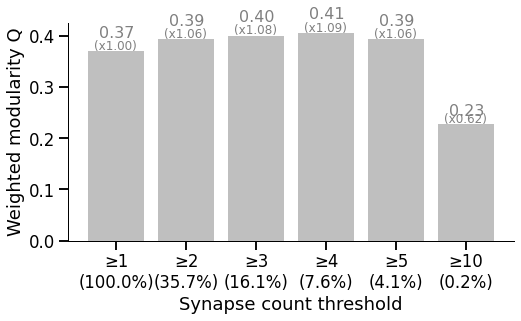

In [266]:
overall_stats(modQ_c, ths_names, ylabel='Synapse count threshold',
              save="mQ-count-remove-weak")

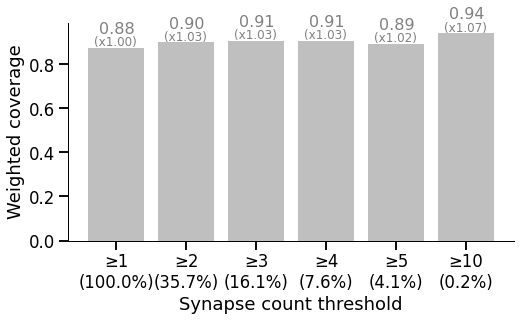

In [267]:
overall_stats(cov_c, ths_names, xlabel='Weighted coverage', ylabel='Synapse count threshold',
             save="wc-count-remove-weak")

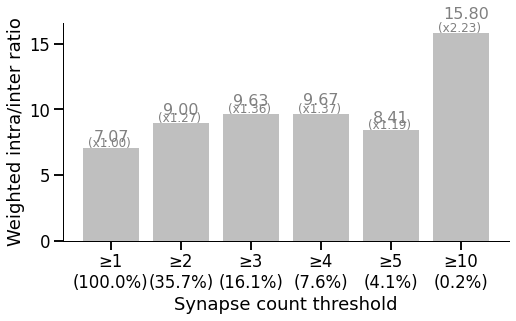

In [269]:
overall_stats(rat_c, ths_names, xlabel='Weighted intra/inter ratio', ylabel='Synapse count threshold',
             save="iir-count-remove-weak")

### Proofread weak-connections

In [12]:
all_synapses

,psd_segid,BBOX_bx,BBOX_by,BBOX_bz,BBOX_ex,BBOX_ey,BBOX_ez,postsyn_sz,postsyn_wt,postsyn_x,...,presyn_wt,presyn_x,presyn_y,presyn_z,size,postsyn_segid,presyn_segid,centroid_x,centroid_y,centroid_z
0,2,15037,20682,16656,15049,20719,16657,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,271,NaN,NaN,15043.0,20700.0,16656.0
1,3,15261,20788,16418,15290,20836,16419,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,253,NaN,NaN,15271.0,20811.0,16418.0
2,4,15358,20534,16389,15345,20527,16389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,259,NaN,NaN,15360.0,20533.0,16390.0
3,6,14673,22039,16487,14678,22100,16488,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,240,NaN,NaN,14675.0,22070.0,16487.0
4,7,15346,22283,16492,15325,22272,16491,25234.0,0.727412,15359.0,...,0.569262,15315.0,22298.0,16500.0,944,266713.0,266721.0,15360.0,22276.0,16492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029004,2720208,83783,43612,17610,83794,43645,17611,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,269,NaN,NaN,83787.0,43628.0,17610.0
2029005,2720210,83065,44257,17610,83109,44269,17611,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,329,NaN,NaN,83087.0,44262.0,17610.0
2029006,2720211,83279,44046,17563,83385,44096,17566,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1800,NaN,NaN,83343.0,44073.0,17564.0
2029007,2720212,83428,44518,17630,83484,44532,17631,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,315,NaN,NaN,83458.0,44524.0,17630.0


In [13]:
annotation_tmp="%7B%22pointA%22:%5B{}%2C{}%2C{}%5D%2C%22pointB%22:%5B{}%2C{}%2C{}%5D%2C%22type%22:%22line%22%2C%22id%22:%22{}%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%22{}%22%2C%22{}%22%5D%7D"

In [14]:
def pf_link(syn_info):
    with open("./saved/ng_template/proofread.txt") as f:
        ng_tmp = f.read()
    annos = []
    for s in syn_info:
        pre_x,pre_y,pre_z,post_x,post_y,post_z,sid,pre_id,post_id = (s[0,i] for i in range(9))
        anno = annotation_tmp.format(int(pre_x),int(pre_y),int(pre_z),
                                     int(post_x),int(post_y),int(post_z),
                                     int(sid),int(pre_id),int(post_id))
        annos.append(anno)
    return ng_tmp.format("%2C".join(annos))

In [17]:
weak_connections = []

In [296]:
for e in u.edges():
    if u.ep["#synapses"][e] == 1:
        weak_connections.append((u.vp["cellid"][e.source()], u.vp["cellid"][e.target()]))

In [20]:
%%time
syn_infos = [np.array(all_synapses[[
                "presyn_x","presyn_y","presyn_z",
               "postsyn_x","postsyn_y","postsyn_z",
               "psd_segid","presyn_segid", "postsyn_segid"]][(all_synapses["presyn_segid"] == w[0]) 
            & (all_synapses["postsyn_segid"] == w[1])]) for w in weak_connections]

In [19]:
syn_exp = pd.DataFrame({"Coordinate 1": [[int(sinfo[0,i]) for i in range(3)] for sinfo in syn_infos],
              "Coordinate 2": [[int(sinfo[0,i+3]) for i in range(3)] for sinfo in syn_infos],
              "Ellipsoid Dimensions":"",
              "Tags":"",
              "Description":"",
              "Segment IDs": ["{},{}".format(int(sinfo[0,7]), int(sinfo[0,8])) for sinfo in syn_infos],
              "Parent ID":"",
              "Type": "Line",
              "ID":"",})
syn_exp.to_csv("./proofread/all_weak.csv", index=False)

In [58]:
strong_connections = []

In [59]:
for e in u.edges():
    if u.ep["#synapses"][e] > 1:
        strong_connections.append((u.vp["cellid"][e.source()], u.vp["cellid"][e.target()]))

In [60]:
%%time
strong_syn_infos = [np.array(all_synapses[[
                "presyn_x","presyn_y","presyn_z",
               "postsyn_x","postsyn_y","postsyn_z",
               "psd_segid","presyn_segid", "postsyn_segid"]][(all_synapses["presyn_segid"] == s[0]) 
            & (all_synapses["postsyn_segid"] == s[1])]) for s in strong_connections]

CPU times: user 1min 27s, sys: 1min 8s, total: 2min 36s
Wall time: 2min 14s


In [61]:
strong_syn_infos = np.concatenate(strong_syn_infos, axis=0)

In [62]:
syn_exp = pd.DataFrame({"Coordinate 1": [[int(sinfo[i]) for i in range(3)] for sinfo in strong_syn_infos],
              "Coordinate 2": [[int(sinfo[i+3]) for i in range(3)] for sinfo in strong_syn_infos],
              "Ellipsoid Dimensions":"",
              "Tags":"",
              "Description":"",
              "Segment IDs": ["{},{}".format(int(sinfo[7]), int(sinfo[8])) for sinfo in strong_syn_infos],
              "Parent ID":"",
              "Type": "Line",
              "ID":"",})
syn_exp.to_csv("./proofread/all_strong.csv", index=False)

In [63]:
def pf_strong_link(syn_info):
    with open("./saved/ng_template/proofread.txt") as f:
        ng_tmp = f.read()
    annos = []
    for s in syn_info:
        pre_x,pre_y,pre_z,post_x,post_y,post_z,sid,pre_id,post_id = (s[i] for i in range(9))
        anno = annotation_tmp.format(int(pre_x),int(pre_y),int(pre_z),
                                     int(post_x),int(post_y),int(post_z),
                                     int(sid),int(pre_id),int(post_id))
        annos.append(anno)
    return ng_tmp.format("%2C".join(annos))

In [65]:
k=33
pf_strong_link(strong_syn_infos[100*(k-1):100*(k)])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/image%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22image%22%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/consensus-20190415%22%2C%22type%22:%22segmentation%22%2C%22ignoreSegmentInteractions%22:true%2C%22loadSkeletons%22:false%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22consensus04152019%22%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/consensus-20190923%22%2C%22type%22:%22segmentation%22%2C%22loadSkeletons%22:false%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22meshref%2809232019%29%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/clefts%22%2C%22type%22:%22segmentation%22%2C%22ignoreSegmentInteract

In [552]:
# k=59
# pf_strong_link(strong_syn_infos[100*(k-1):])

In [419]:
len(strong_syn_infos)

5868

In [427]:
len(syn_infos)

3603

In [666]:
check_infos = [np.array(all_synapses[[
                "presyn_x","presyn_y","presyn_z",
               "postsyn_x","postsyn_y","postsyn_z",
               "psd_segid","presyn_segid", "postsyn_segid"]][(all_synapses["presyn_segid"] == w[0]) 
            & (all_synapses["postsyn_segid"] == w[1])]) for w in large_weak]

In [667]:
check_infos

[array([[  56303.,   20904.,   16873.,   56316.,   20939.,   16882.,
         1300921.,   76561.,   77099.]]),
 array([[  54925.,   23422.,   17221.,   54883.,   23526.,   17230.,
         1236200.,   76887.,   79553.]])]

In [669]:
pf_link(check_infos)

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/image%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22image%22%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/consensus-20190415%22%2C%22type%22:%22segmentation%22%2C%22ignoreSegmentInteractions%22:true%2C%22loadSkeletons%22:false%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22consensus04152019%22%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/consensus-20190923%22%2C%22type%22:%22segmentation%22%2C%22loadSkeletons%22:false%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22meshref%2809232019%29%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/clefts%22%2C%22type%22:%22segmentation%22%2C%22ignoreSegmentInteract

In [692]:
all_synapses[all_synapses['psd_segid']== 1236200]

,psd_segid,BBOX_bx,BBOX_by,BBOX_bz,BBOX_ex,BBOX_ey,BBOX_ez,postsyn_sz,postsyn_wt,postsyn_x,...,presyn_wt,presyn_x,presyn_y,presyn_z,size,postsyn_segid,presyn_segid,centroid_x,centroid_y,centroid_z
914117,1236200,54931,23499,17223,54942,23510,17228,113237.0,0.71694,54883.0,...,0.85711,54925.0,23422.0,17221.0,11233,79553.0,76887.0,54878.0,23551.0,17225.0


In [693]:
all_synapses[all_synapses['psd_segid']== 1300921]

,psd_segid,BBOX_bx,BBOX_by,BBOX_bz,BBOX_ex,BBOX_ey,BBOX_ez,postsyn_sz,postsyn_wt,postsyn_x,...,presyn_wt,presyn_x,presyn_y,presyn_z,size,postsyn_segid,presyn_segid,centroid_x,centroid_y,centroid_z
959940,1300921,56302,20857,16872,56360,20891,16898,286.0,0.943278,56316.0,...,0.918161,56303.0,20904.0,16873.0,12089,77099.0,76561.0,56320.542228,20901.828356,16883.073538


In [690]:
[np.array(all_synapses[["psd_segid"]][(all_synapses["presyn_segid"] == w[0]) 
            & (all_synapses["postsyn_segid"] == w[1])]) for w in large_weak]

[array([[1300921]]), array([[1236200]])]